## 1. Data Exploration & PreProcessing

In [1]:
def generate_word_cloud(file, column):
    import nltk
    import pandas as pd
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    from nltk.corpus import stopwords 
    try:
        nltk.data.find('/Users/maddenri/nltk_data/')
    except LookupError:
        nltk.download('stopwords')
    
    stopwords = nltk.corpus.stopwords.words('english')
    df = pd.read_csv(file)
    comment_words = ''
    for val in df[column]: 
        val = str(val)
        tokens = val.split()
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()  
        comment_words += " ".join(tokens)
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white', regexp=None, max_words=100,
                    normalize_plurals=False, min_font_size = 10).generate(comment_words)                  
    plt.figure(figsize = (6, 6), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

In [2]:
def generate_word_frequency(file, text_column):
    import nltk
    import pandas as pd
    import matplotlib.pyplot as plt
    from nltk.probability import FreqDist
    try:
        nltk.data.find('/Users/maddenri/nltk_data/')
    except LookupError:
        nltk.download('stopwords')
    
    stopwords = nltk.corpus.stopwords.words('english')
    df= pd.read_csv(file)
    df_string = ' '.join(df[text_column].dropna())
    mostcommon_small = FreqDist([word for word in df_string.split() 
                                 if word not in stopwords]).most_common(25)
    x, y = zip(*mostcommon_small)
    plt.figure(figsize=(10,6))
    plt.margins(0.02)
    plt.bar(x, y)
    plt.xlabel('Words', fontsize=20)
    plt.ylabel('Frequency of Words', fontsize=20)
    plt.yticks(fontsize=16)
    plt.xticks(rotation=60, fontsize=16)
    plt.title('Frequency of 25 Most Common Words', fontsize=20)
    plt.show()

In [3]:
def preprocess_text_column(input_file, output_file):
    '''(i)   merge "title" and "text" into a single "news_content" column
       (ii)  convert all words to lowercase
       (iii) removed all unlabelled instances'''
    import re
    import nltk
    import pandas as pd
    import numpy as np

    df=pd.read_csv(input_file)
    df['news_content'] = np.where(df['title'].isnull(), df['text'], 
                              np.where(df['text'].isnull(), df['title'], 
                                           df['title'] + '. ' +  df['text']))
    df['news_content'] = df['news_content'].str.lower()
    df['title'] = df['title'].str.lower().fillna('')
    df['text'] = df['text'].str.lower().fillna('')
    df = df[['title','text','news_content','label']].dropna().reset_index(drop=True)
    df.to_csv(output_file, index=False)

In [4]:
preprocess_text_column('../Datasets/Original/dataset_i.csv', '../Datasets/Preprocessed/dataset_i.csv')
preprocess_text_column('../Datasets/Original/dataset_ii.csv', '../Datasets/Preprocessed/dataset_ii.csv')

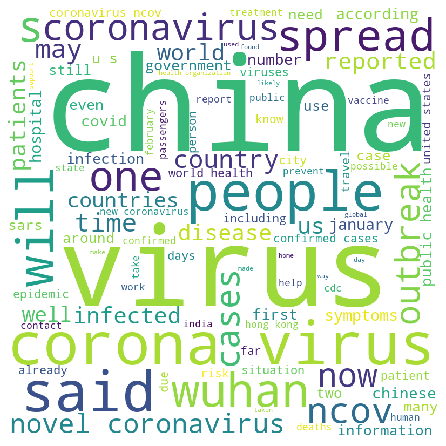

In [6]:
generate_word_cloud('../Datasets/Preprocessed/dataset_i.csv', 'news_content')

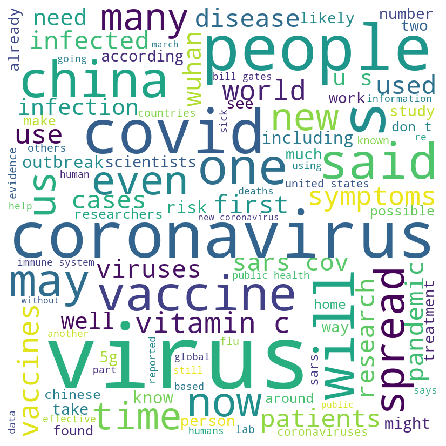

In [7]:
generate_word_cloud('../Datasets/Preprocessed/dataset_ii.csv', 'news_content')

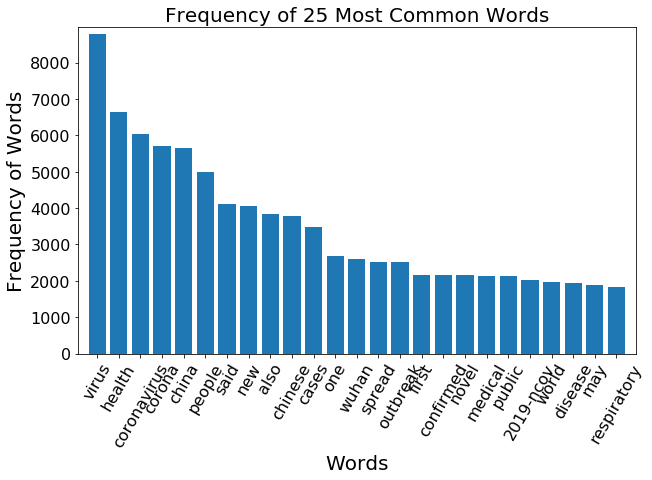

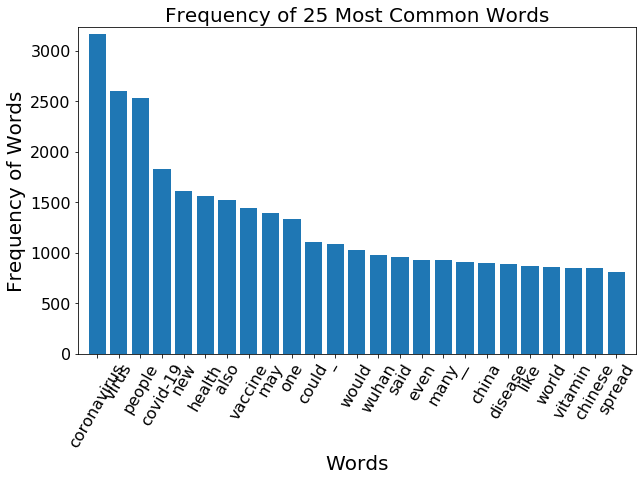

In [8]:
generate_word_frequency('../Datasets/Preprocessed/dataset_i.csv', 'news_content')
generate_word_frequency('../Datasets/Preprocessed/dataset_ii.csv', 'news_content')

# 2. Bag of Words

In [9]:
import pandas as pd
from pprint import pprint
from nltk.tokenize import word_tokenize
df= pd.read_csv('../Datasets/Preprocessed/dataset_ii.csv')

In [10]:
bow = pd.Series([' '.join(['"{}"'.format(word) for word in word_tokenize(doc)]) for doc in df['news_content'][1043:1044]])
bow

0    "bill" "gates" "predicted" "that" "the" "coron...
dtype: object

In [11]:
bow[0]

'"bill" "gates" "predicted" "that" "the" "coronavirus" "pandemic" "would" "kill" "65" "million" "people" "and" "created" "a" "vaccine" "to" "eradicate" "africans"'

In [12]:
def generate_bag_of_words(series):
    import pandas as pd
    from nltk.tokenize import word_tokenize
    return pd.Series([' '.join(['"{}"'.format(word) for word in word_tokenize(doc)]) for doc in series]) 

# 3. POS Tags

In [13]:
from nltk import pos_tag, sent_tokenize
pos_list = [pos_tag(word_tokenize(doc)) for doc in df['news_content'][1043:1044]]
pos_list[0]

[('bill', 'NN'),
 ('gates', 'NNS'),
 ('predicted', 'VBD'),
 ('that', 'IN'),
 ('the', 'DT'),
 ('coronavirus', 'NN'),
 ('pandemic', 'NN'),
 ('would', 'MD'),
 ('kill', 'VB'),
 ('65', 'CD'),
 ('million', 'CD'),
 ('people', 'NNS'),
 ('and', 'CC'),
 ('created', 'VBD'),
 ('a', 'DT'),
 ('vaccine', 'NN'),
 ('to', 'TO'),
 ('eradicate', 'VB'),
 ('africans', 'NNS')]

In [14]:
res = {}
for k, v in pos_list[0]:
    res[v] = res.get(v, 0) + 1
res

{'NN': 4,
 'NNS': 3,
 'VBD': 2,
 'IN': 1,
 'DT': 2,
 'MD': 1,
 'VB': 2,
 'CD': 2,
 'CC': 1,
 'TO': 1}

In [15]:
pos = pd.Series([' '.join([tag[1] for tag in doc]) for doc in pos_list])
pos

0    NN NNS VBD IN DT NN NN MD VB CD CD NNS CC VBD ...
dtype: object

In [16]:
pos[0]

'NN NNS VBD IN DT NN NN MD VB CD CD NNS CC VBD DT NN TO VB NNS'

In [17]:
def generate_part_of_speech_tags(series):
    '''Uses Penn Treebank tagset - https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html'''
    import pandas as pd
    from nltk import pos_tag
    from nltk.tokenize import word_tokenize
    pos_list = [pos_tag(word_tokenize(doc)) for doc in series]
    return pd.Series([' '.join([tag[1] for tag in doc]) for doc in pos_list])

# 4. Standford Core NLP server

### 4.1 - CFG Production Rules  -> File

In [18]:
def news_content_to_files(file, output):
    import os
    import pandas as pd
    from os.path import join

    if not os.path.exists(output):
        os.makedirs(output)
    series= pd.read_csv(file)['news_content']
    for count, value in enumerate(series):
        with open(join(output,f'file_{count}'), 'w') as text_file:
            text_file.write(value)

In [18]:
news_content_to_files('../Datasets/Preprocessed/dataset_i.csv', '../Datasets/news_content_files/dataset_i')
news_content_to_files('../Datasets/Preprocessed/dataset_ii.csv', '../Datasets/news_content_files/dataset_ii')

In [19]:
def generate_cfg_parse_docs(path):
    import glob
    import os
    from os.path import join
    from xml import etree
    from nltk import Tree
    from corenlp_xml.document import Document

    new_cfg_trees = list()
    for root, dirs, files in os.walk(path):
        for name in files:
            if name.endswith('.xml'):
                file = join(root, name)          
                et_root = etree.ElementTree.parse(file).getroot()
                xmlstr = etree.ElementTree.tostring(et_root, encoding='unicode', method='xml')
                doc = Document(xmlstr)
                sentences = [' '.join([w.word for w in sentence.tokens]) for sentence in list(doc.sentences)]
                parse_trees = [Tree.fromstring(sentence.parse_string) for sentence in list(doc.sentences)]
                with open(file.replace('.xml','.parse'),'w') as f:  
                    parse_doc_string = ' '.join([str(rule).replace(' ', '') for sentence in parse_trees for rule in sentence.productions()])
                    f.write(parse_doc_string)

In [ ]:
generate_cfg_parse_docs('../Datasets/news_content_files/dataset_i')
generate_cfg_parse_docs('../Datasets/news_content_files/dataset_ii')

### 4.2 - Discourse Rhetorical Relationships  -> File

In [19]:
%%sh
cd "../RR_DPLP_Parser"
/Library/Frameworks/Python.framework/Versions/2.7/bin/python convert.py ../Datasets/news_content_files/dataset_i
/Library/Frameworks/Python.framework/Versions/2.7/bin/python convert.py ../Datasets/news_content_files/dataset_ii

Processing file: ../Datasets/news_content_files/dataset_i/file_79.xml
Processing file: ../Datasets/news_content_files/dataset_i/file_1976.xml
Processing file: ../Datasets/news_content_files/dataset_i/file_788.xml
Processing file: ../Datasets/news_content_files/dataset_i/file_950.xml
Processing file: ../Datasets/news_content_files/dataset_i/file_944.xml
Processing file: ../Datasets/news_content_files/dataset_i/file_1962.xml
Processing file: ../Datasets/news_content_files/dataset_i/file_45.xml
Processing file: ../Datasets/news_content_files/dataset_i/file_1792.xml
Processing file: ../Datasets/news_content_files/dataset_i/file_1786.xml
Processing file: ../Datasets/news_content_files/dataset_i/file_978.xml
Processing file: ../Datasets/news_content_files/dataset_i/file_51.xml
Processing file: ../Datasets/news_content_files/dataset_i/file_2502.xml
Processing file: ../Datasets/news_content_files/dataset_i/file_993.xml
Processing file: ../Datasets/news_content_files/dataset_i/file_2264.xml
Pro

In [20]:
%%sh
cd "../RR_DPLP_Parser"
/Library/Frameworks/Python.framework/Versions/2.7/bin/python segmenter.py ../Datasets/news_content_files/dataset_i/
/Library/Frameworks/Python.framework/Versions/2.7/bin/python segmenter.py ../Datasets/news_content_files/dataset_ii/

Load model from: discoseg/pretrained/model.pickle.gz
Processing file: ../Datasets/news_content_files/dataset_i/file_739.conll
Processing file: ../Datasets/news_content_files/dataset_i/file_1668.conll
Processing file: ../Datasets/news_content_files/dataset_i/file_1145.conll
Processing file: ../Datasets/news_content_files/dataset_i/file_1906.conll
Processing file: ../Datasets/news_content_files/dataset_i/file_1594.conll
Processing file: ../Datasets/news_content_files/dataset_i/file_1100.conll
Processing file: ../Datasets/news_content_files/dataset_i/file_1943.conll
Processing file: ../Datasets/news_content_files/dataset_i/file_857.conll
Processing file: ../Datasets/news_content_files/dataset_i/file_2233.conll
Processing file: ../Datasets/news_content_files/dataset_i/file_480.conll
Processing file: ../Datasets/news_content_files/dataset_i/file_812.conll
Processing file: ../Datasets/news_content_files/dataset_i/file_2276.conll
Processing file: ../Datasets/news_content_files/dataset_i/file_

In [21]:
%%sh
cd "../RR_DPLP_Parser"
/Library/Frameworks/Python.framework/Versions/2.7/bin/python rstparser.py ../Datasets/news_content_files/dataset_i
/Library/Frameworks/Python.framework/Versions/2.7/bin/python rstparser.py ../Datasets/news_content_files/dataset_ii

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# 5. CFG Production Rules

1. Run the following from a separate shell:

java -Xmx1024M -cp "/Users/maddenri/Documents/MSc Software Dev/Thesis/StandfordParser/stanford-corenlp-4.5.2/*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 1500000

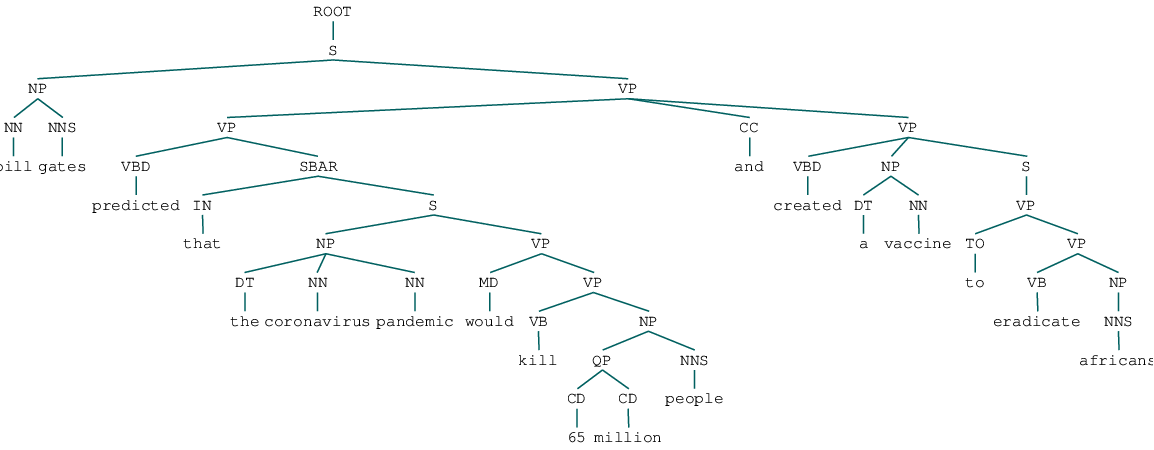

In [20]:
from nltk.parse import CoreNLPParser
parser = CoreNLPParser(url='http://localhost:9000')
parser.session.trust_env = False

cfg_trees = [list(parser.parse_text(doc)) for doc in df['news_content'][1043:1044]]
cfg_trees[0][0]

In [21]:
cfg_trees[0][0].productions()

[ROOT -> S,
 S -> NP VP,
 NP -> NN NNS,
 NN -> 'bill',
 NNS -> 'gates',
 VP -> VP CC VP,
 VP -> VBD SBAR,
 VBD -> 'predicted',
 SBAR -> IN S,
 IN -> 'that',
 S -> NP VP,
 NP -> DT NN NN,
 DT -> 'the',
 NN -> 'coronavirus',
 NN -> 'pandemic',
 VP -> MD VP,
 MD -> 'would',
 VP -> VB NP,
 VB -> 'kill',
 NP -> QP NNS,
 QP -> CD CD,
 CD -> '65',
 CD -> 'million',
 NNS -> 'people',
 CC -> 'and',
 VP -> VBD NP S,
 VBD -> 'created',
 NP -> DT NN,
 DT -> 'a',
 NN -> 'vaccine',
 S -> VP,
 VP -> TO VP,
 TO -> 'to',
 VP -> VB NP,
 VB -> 'eradicate',
 NP -> NNS,
 NNS -> 'africans']

In [22]:
production_rules = pd.Series([' '.join([str(rule).replace(' ', '') for sentence in doc 
           for rule in sentence.productions()]) for doc in cfg_trees])
production_rules

0    ROOT->S S->NPVP NP->NNNNS NN->'bill' NNS->'gat...
dtype: object

In [23]:
production_rules[0]

"ROOT->S S->NPVP NP->NNNNS NN->'bill' NNS->'gates' VP->VPCCVP VP->VBDSBAR VBD->'predicted' SBAR->INS IN->'that' S->NPVP NP->DTNNNN DT->'the' NN->'coronavirus' NN->'pandemic' VP->MDVP MD->'would' VP->VBNP VB->'kill' NP->QPNNS QP->CDCD CD->'65' CD->'million' NNS->'people' CC->'and' VP->VBDNPS VBD->'created' NP->DTNN DT->'a' NN->'vaccine' S->VP VP->TOVP TO->'to' VP->VBNP VB->'eradicate' NP->NNS NNS->'africans'"

In [24]:
def generate_cfg_productions(path):
    import os
    from os.path import join
    import pandas as pd
    
    production_rules = list()
    files = sorted([name for name in os.listdir(path) 
                     if os.path.isfile(join(path,name)) and name.endswith('.parse')]
                   ,key=lambda x: int(x.split('_')[-1].split('.')[0]), reverse=False)
    
    for file in files:
        with open(join(path,file), 'r') as f:
                    production_rules.append(f.read())
    return pd.Series(production_rules)

# 6. Discourse - Rhetorical Relationships

In [25]:
def generate_rhetorical_relationships(path):
    import os
    import re
    from os.path import join, isfile, basename, dirname
    import pandas as pd

    rhetorical_relationships = list()
    if isfile(path):
        files = [basename(path) if path.endswith('.brackets') else None]
        path = dirname(path)
    else:
        files = sorted([name for name in os.listdir(path) 
                    if os.path.isfile(join(path,name)) and name.endswith('.brackets')]
                   ,key=lambda x: int(x.split('_')[-1].split('.')[0]), reverse=False)

    for file in files:
        with open(join(path,file), 'r') as f:
            doc = ' '.join([' '.join([rr.replace(' ', '').lower() 
                      for rr in rule[1:-2].replace("'","").rsplit(',',2)]) 
                          for rule in f.readlines()])
            doc = re.sub('\(\d+,\d+\)\s', '', doc) 
            rhetorical_relationships.append(doc)
    return pd.Series(rhetorical_relationships)

In [26]:
rewrite_rules = generate_rhetorical_relationships('../Datasets/news_content_files/dataset_ii/file_1043.brackets')
rewrite_rules

0    satellite attribution nucleus list nucleus spa...
dtype: object

In [27]:
rewrite_rules[0]

'satellite attribution nucleus list nucleus span satellite purpose nucleus list nucleus span'

# 7. Semantic Features

## LIWC Analysis

In [28]:
def perform_liwc(in_file, out_file, col):
    import subprocess
    cmd = ["/Applications/LIWC-22.app/Contents/MacOS/LIWC-22-cli",
                  "--mode", "wc",
                  "--input", in_file,
                  "--column-indices", col,
                  "--output", out_file]
    subprocess.call(cmd)

In [2]:
perform_liwc('../Datasets/Preprocessed/dataset_i.csv', '../Datasets/LIWC/dataset_i_title.csv', '1')
perform_liwc('../Datasets/Preprocessed/dataset_i.csv', '../Datasets/LIWC/dataset_i_text.csv', '2')
perform_liwc('../Datasets/Preprocessed/dataset_ii.csv', '../Datasets/LIWC/dataset_ii_title.csv', '1')
perform_liwc('../Datasets/Preprocessed/dataset_ii.csv', '../Datasets/LIWC/dataset_ii_text.csv', '2')

# 7.1 Disinformation-related Attributes (DIAs)

### Quality - Informality

In [29]:
def get_informality_features(liwc_file):
    import pandas as pd
    df = pd.read_csv(liwc_file)[['WC','swear','netspeak','assent','nonflu','filler', 'Conversation']]
    df.loc[df['WC']==0, :] = None
    df.columns = ['WC','Swear','Netspeak','Assent','Nonfluencies','Fillers', 'Conversation']
    return df.drop(['WC'], axis=1)

In [30]:
q_inform_dataset_i = get_informality_features('../Datasets/LIWC/dataset_i_text.csv')
q_inform_dataset_ii = get_informality_features('../Datasets/LIWC/dataset_ii_text.csv')

In [31]:
q_inform_dataset_ii[308:]

,Swear,Netspeak,Assent,Nonfluencies,Fillers,Conversation
308,0.0,0.17,0.08,0.0,0.0,0.25
309,NaN,NaN,NaN,NaN,NaN,NaN
310,0.0,0.00,0.00,0.0,0.0,0.00
311,0.0,0.00,0.00,0.0,0.0,0.00
312,0.0,0.00,0.08,0.0,0.0,0.08
...,...,...,...,...,...,...
1154,0.0,0.10,0.00,0.0,0.0,0.10
1155,0.0,0.00,0.00,0.0,0.0,0.00
1156,0.0,0.00,0.00,0.0,0.0,0.00
1157,0.0,0.00,0.04,0.0,0.0,0.04


In [32]:
q_inform_dataset_ii[1043:1044]

,Swear,Netspeak,Assent,Nonfluencies,Fillers,Conversation
1043,0.0,0.0,0.0,0.0,0.0,0.0


### Quality - Diversity

In [33]:
def get_diversity_features(file):
    import pandas as pd
    import numpy as np
    from nltk import pos_tag
    from nltk.tokenize import word_tokenize
    div_features = list()
    columns=['# Unique Words', '% Unique Words', '# Unique Content Words', '% Unique Content Words',
             '# Unique Nouns', '% Unique Nouns', '# Unique Verbs', '% Unique Verbs',
             '# Unique Adjectives', '% Unique Adjectives', '# Unique Adverbs', '% Unique Adverbs']
    df= pd.read_csv(file)[['text','label']]
    bow_list = [word_tokenize(doc) if not pd.isnull(doc) else None for doc in df['text']] 
    pos_list = [pos_tag(doc) if doc is not None else None for doc in bow_list] 
    for bow, pos in zip(bow_list, pos_list):
        unique_words_t = len(set(bow)) if bow is not None else np.nan
        unique_words_f = (unique_words_t / len(bow)) if bow is not None else np.nan
        unique_noun_t = len(set([tag[0] for tag in pos if tag[1].startswith('NN')])) if pos is not None else np.nan
        unique_noun_f = (unique_noun_t / len(bow)) if bow is not None else np.nan
        unique_verb_t = len(set([tag[0] for tag in pos if tag[1].startswith('VB')])) if pos is not None else np.nan
        unique_verb_f = (unique_verb_t / len(bow)) if bow is not None else np.nan
        unique_adjec_t = len(set([tag[0] for tag in pos if tag[1].startswith('JJ')])) if pos is not None else np.nan
        unique_adjec_f = (unique_adjec_t / len(bow)) if bow is not None else np.nan
        unique_adverb_t = len(set([tag[0] for tag in pos if tag[1].startswith('RB')])) if pos is not None else np.nan
        unique_adverb_f = (unique_adverb_t / len(bow)) if bow is not None else np.nan
        unique_content_t = (unique_noun_t + unique_verb_t + unique_adjec_t + unique_adverb_t) if unique_noun_t is not None else np.nan
        unique_content_f = (unique_content_t / len(bow)) if bow is not None else np.nan
        div_features.append((unique_words_t, unique_words_f, unique_content_t, unique_content_f, 
                        unique_noun_t, unique_noun_f, unique_verb_t, unique_verb_f,
                        unique_adjec_t, unique_adjec_f, unique_adverb_t, unique_adverb_f))

    return pd.DataFrame(div_features, columns=columns, dtype=object)

In [34]:
diversity_dataset_i = get_diversity_features('../Datasets/Preprocessed/dataset_i.csv')
diversity_dataset_ii = get_diversity_features('../Datasets/Preprocessed/dataset_ii.csv')

In [35]:
diversity_dataset_ii[308:]

,# Unique Words,% Unique Words,# Unique Content Words,% Unique Content Words,# Unique Nouns,% Unique Nouns,# Unique Verbs,% Unique Verbs,# Unique Adjectives,% Unique Adjectives,# Unique Adverbs,% Unique Adverbs
308,527,0.398638,483,0.365356,234,0.177005,126,0.0953101,91,0.0688351,32,0.0242057
309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310,336,0.413284,303,0.372694,138,0.169742,85,0.104551,65,0.0799508,15,0.0184502
311,281,0.544574,236,0.457364,109,0.21124,60,0.116279,56,0.108527,11,0.0213178
312,574,0.382922,499,0.332889,234,0.156104,122,0.0813876,100,0.0667111,43,0.0286858
...,...,...,...,...,...,...,...,...,...,...,...,...
1154,513,0.435854,474,0.402719,228,0.193713,111,0.0943076,95,0.0807137,40,0.0339847
1155,621,0.36337,557,0.325922,247,0.144529,153,0.089526,122,0.0713868,35,0.0204798
1156,381,0.442509,334,0.387921,159,0.184669,78,0.0905923,72,0.0836237,25,0.029036
1157,955,0.333566,897,0.313308,391,0.13657,243,0.084876,185,0.0646175,78,0.0272441


In [36]:
diversity_dataset_ii[1043:1044]

,# Unique Words,% Unique Words,# Unique Content Words,% Unique Content Words,# Unique Nouns,% Unique Nouns,# Unique Verbs,% Unique Verbs,# Unique Adjectives,% Unique Adjectives,# Unique Adverbs,% Unique Adverbs
1043,19,1,11,0.578947,7,0.368421,4,0.210526,0,0,0,0


### Quality - Subjectivity

In [37]:
def get_subjectivity_features(file):
    import pandas as pd
    import numpy as np
    from nltk import pos_tag
    from nltk.tokenize import word_tokenize
    sub_features = list()
    columns=['# Biased Lexicons', '% Biased Lexicons', '# Report Verbs', '% Report Verbs', 
             '# Factive Verbs', '% Factive Verbs']
    df= pd.read_csv(file)[['text','label']]
    
    with open('../Datasets/bias-lexicon/bias-lexicon.txt') as f:
        biased_lexicons = [line.strip() for line in f.readlines()]
    with open('../Datasets/bias_related_lexicons/report_verbs.txt') as f:
        report_verbs = [line.strip() for line in f.readlines()[9:]]
    with open('../Datasets/bias_related_lexicons/factives_hooper1975.txt') as f:
        factive_verbs = [line.strip() for line in f.readlines()[7:]]
    
    for bow in [word_tokenize(doc) if not pd.isnull(doc) else None for doc in df['text']]:  
        wc = len(bow) if bow is not None else np.nan
        bl_c = sum([bow.count(w) for w in biased_lexicons]) if bow is not None else np.nan
        bl_p = bl_c/wc if bow is not None else np.nan
        rv_c = sum([bow.count(w) for w in report_verbs]) if bow is not None else np.nan
        rv_p = rv_c/wc if bow is not None else np.nan
        fv_c = sum([bow.count(w) for w in factive_verbs]) if bow is not None else np.nan  
        fv_p = fv_c/wc if bow is not None else np.nan
        sub_features.append((bl_c, bl_p, rv_c, rv_p, fv_c, fv_p))
    
    return pd.DataFrame(sub_features, columns=columns, dtype=object)

In [38]:
subjectivity_dataset_i = get_subjectivity_features('../Datasets/Preprocessed/dataset_i.csv')
subjectivity_dataset_ii = get_subjectivity_features('../Datasets/Preprocessed/dataset_ii.csv')

In [39]:
subjectivity_dataset_ii[308:]

,# Biased Lexicons,% Biased Lexicons,# Report Verbs,% Report Verbs,# Factive Verbs,% Factive Verbs
308,139,0.105144,14,0.01059,2,0.00151286
309,NaN,NaN,NaN,NaN,NaN,NaN
310,63,0.0774908,5,0.00615006,2,0.00246002
311,38,0.0736434,10,0.0193798,0,0
312,109,0.0727151,11,0.00733823,6,0.00400267
...,...,...,...,...,...,...
1154,107,0.0909091,11,0.00934579,3,0.00254885
1155,134,0.0784084,32,0.0187244,6,0.00351083
1156,84,0.097561,20,0.0232288,2,0.00232288
1157,244,0.0852253,26,0.00908138,5,0.00174642


In [40]:
subjectivity_dataset_ii[1043:1044]

,# Biased Lexicons,% Biased Lexicons,# Report Verbs,% Report Verbs,# Factive Verbs,% Factive Verbs
1043,2,0.105263,0,0,0,0


### Sentiment

In [41]:
def get_sentiment_features(liwc_file):
    import pandas as pd
    df = pd.read_csv(liwc_file)[['WC', 'Tone','Affect','tone_pos','tone_neg','emotion',
                                 'emo_pos','emo_neg','emo_anx','emo_anger','emo_sad']]
    df.loc[df['WC']==0, :] = None 
    df.columns = ['WC','Tone','Affect','Positive Tone','Negative Tone','Emotion', 'Positive Emotion',
                  'Negative Emotion', 'Anxiety', 'Anger', 'Sadness']
    return df.drop(['WC'], axis=1)

In [42]:
sent_dataset_i = get_sentiment_features('../Datasets/LIWC/dataset_i_text.csv')
sent_dataset_ii = get_sentiment_features('../Datasets/LIWC/dataset_ii_text.csv')

In [43]:
sent_dataset_ii[308:]

,Tone,Affect,Positive Tone,Negative Tone,Emotion,Positive Emotion,Negative Emotion,Anxiety,Anger,Sadness
308,10.27,3.03,1.01,2.02,0.59,0.08,0.42,0.00,0.17,0.00
309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310,27.28,1.07,0.80,0.27,0.13,0.13,0.00,0.00,0.00,0.00
311,7.29,2.28,0.41,1.86,0.00,0.00,0.00,0.00,0.00,0.00
312,40.02,3.61,2.48,1.13,0.30,0.15,0.15,0.08,0.00,0.15
...,...,...,...,...,...,...,...,...,...,...
1154,19.08,2.92,1.36,1.46,0.29,0.10,0.00,0.00,0.00,0.00
1155,13.89,2.80,1.11,1.69,0.65,0.07,0.39,0.20,0.00,0.00
1156,20.23,2.38,1.19,1.19,0.66,0.66,0.00,0.00,0.00,0.00
1157,38.46,2.91,2.09,0.83,0.67,0.39,0.24,0.04,0.04,0.04


In [44]:
sent_dataset_ii[1043:1044]

,Tone,Affect,Positive Tone,Negative Tone,Emotion,Positive Emotion,Negative Emotion,Anxiety,Anger,Sadness
1043,1.0,10.53,0.0,10.53,0.0,0.0,0.0,0.0,0.0,0.0


### Quantity

In [45]:
def get_quantity_counts(file):
    import pandas as pd
    import numpy as np
    import textstat as ts
    import readability as r
    from nltk.tokenize import sent_tokenize, word_tokenize
    
    def paragraph_count(doc):
        return len(doc.split('\n\n'))
    
    def sents_per_paragraph(doc):
        p_count = paragraph_count(doc)
        if p_count < 1:
            return ts.sentence_count(doc)
        return float(ts.sentence_count(doc) / p_count)

    columns=['# Characters','# Words','# Sentences','# Paragraphs',
             'Avg. # Characters per Word','Avg. # Words per Sentence','Avg. # Sentences per Paragraph']
    df= pd.read_csv(file)[['text','label']]
    r_scores = [(ts.char_count(doc) if not pd.isnull(doc) else np.nan,
                ts.lexicon_count(doc) if not pd.isnull(doc) else np.nan,
                ts.sentence_count(doc) if not pd.isnull(doc) else np.nan,
                paragraph_count(doc) if not pd.isnull(doc) else np.nan,
                ts.avg_character_per_word(doc) if not pd.isnull(doc) else np.nan,
                ts.words_per_sentence(doc) if not pd.isnull(doc) else np.nan,
                sents_per_paragraph(doc) if not pd.isnull(doc) else np.nan
                )
                for doc in df['text']]
    return pd.DataFrame(r_scores, columns=columns, dtype=object)

In [46]:
quantity_dataset_i = get_quantity_counts('../Datasets/Preprocessed/dataset_i.csv')
quantity_dataset_ii = get_quantity_counts('../Datasets/Preprocessed/dataset_ii.csv')

In [47]:
quantity_dataset_ii[308:]

,# Characters,# Words,# Sentences,# Paragraphs,Avg. # Characters per Word,Avg. # Words per Sentence,Avg. # Sentences per Paragraph
308,6364,1161,57,1,5.48,20.3684,57
309,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310,4043,735,27,1,5.5,27.2222,27
311,2571,469,23,1,5.48,20.3913,23
312,6942,1314,68,1,5.28,19.3235,68
...,...,...,...,...,...,...,...
1154,5490,1009,45,1,5.44,22.4222,45
1155,8107,1506,69,1,5.38,21.8261,69
1156,3882,741,30,1,5.24,24.7,30
1157,12821,2455,157,1,5.22,15.6369,157


In [48]:
quantity_dataset_ii[1043:1044]

,# Characters,# Words,# Sentences,# Paragraphs,Avg. # Characters per Word,Avg. # Words per Sentence,Avg. # Sentences per Paragraph
1043,105,19,1,1,5.53,19,1


### Specificity - Cognitive Process

In [49]:
def get_cognitive_features(liwc_file):
    import pandas as pd
    df = pd.read_csv(liwc_file)[['WC','insight','cause','discrep',
                                 'tentat','certitude','differ','cogproc']]
    df.loc[df['WC']==0, :] = None
    df.columns = ['WC','Insight','Causation','Discrepancy','Tentative',
                      'Certitude','Differentiation','Cognitive Processes']
        
    return df.drop(['WC'], axis=1)

In [50]:
cog_dataset_i = get_cognitive_features('../Datasets/LIWC/dataset_i_text.csv')
cog_dataset_ii = get_cognitive_features('../Datasets/LIWC/dataset_ii_text.csv')

In [51]:
cog_dataset_ii[308:]

,Insight,Causation,Discrepancy,Tentative,Certitude,Differentiation,Cognitive Processes
308,2.95,1.77,0.93,0.84,0.34,2.44,8.92
309,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310,3.07,1.60,0.93,1.07,0.00,2.27,9.20
311,2.07,2.07,0.62,1.66,0.00,2.48,8.28
312,1.35,2.03,1.73,1.96,0.30,3.99,10.46
...,...,...,...,...,...,...,...
1154,2.33,2.04,1.56,2.24,0.10,3.70,11.19
1155,3.00,1.83,1.24,1.96,0.20,2.61,10.56
1156,2.51,1.32,1.32,2.11,0.53,4.23,11.36
1157,1.54,1.89,2.24,3.66,0.51,4.06,12.17


In [52]:
cog_dataset_ii[1043:1044]

,Insight,Causation,Discrepancy,Tentative,Certitude,Differentiation,Cognitive Processes
1043,0.0,0.0,5.26,0.0,0.0,0.0,10.53


### Specificity - Perceptual Process

In [53]:
def get_perceptual_features(liwc_file):
    import pandas as pd
    df = pd.read_csv(liwc_file)[['WC','visual','auditory','feeling',
                                 'attention','motion', 'space', 'Perception']]
    df.loc[df['WC']==0, :] = None
    df.columns = ['WC','Visual','Auditory','Feeling','Attention','Motion','Space','Perception']
    return df.drop(['WC'], axis=1)

In [54]:
percep_dataset_i = get_perceptual_features('../Datasets/LIWC/dataset_i_text.csv')
percep_dataset_ii = get_perceptual_features('../Datasets/LIWC/dataset_ii_text.csv')

In [55]:
percep_dataset_ii[308:]

,Visual,Auditory,Feeling,Attention,Motion,Space,Perception
308,0.67,0.08,0.25,0.42,1.43,5.89,8.50
309,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310,0.67,0.00,0.00,0.53,1.60,6.80,9.20
311,0.83,0.00,0.00,0.41,0.83,6.42,7.87
312,0.38,0.00,0.15,0.30,0.98,6.17,7.52
...,...,...,...,...,...,...,...
1154,1.46,0.00,0.39,0.49,1.07,5.06,8.37
1155,0.65,0.00,0.13,0.33,1.30,5.41,7.82
1156,1.45,0.00,1.19,0.00,1.32,6.74,10.30
1157,0.63,0.04,0.04,0.31,1.57,5.12,7.52


In [56]:
percep_dataset_ii[1043:1044]

,Visual,Auditory,Feeling,Attention,Motion,Space,Perception
1043,0.0,0.0,0.0,0.0,0.0,5.26,5.26


# -----------------------------------------------------------------------------------

In [57]:
def all_dia_features(liwc_file, p_file):
    """Missing values are imputed with mean of each feature"""
    import pandas as pd
    df = pd.concat([get_informality_features(liwc_file), get_diversity_features(p_file),
                    get_subjectivity_features(p_file), get_sentiment_features(liwc_file), 
                    get_quantity_counts(p_file), get_cognitive_features(liwc_file),
                    get_perceptual_features(liwc_file)], axis=1)
    return df.fillna(df.mean())

In [58]:
dia_dataset_i =  all_dia_features('../Datasets/LIWC/dataset_i_text.csv',
                                 '../Datasets/Preprocessed/dataset_i.csv')
dia_dataset_ii = all_dia_features('../Datasets/LIWC/dataset_ii_text.csv',
                                 '../Datasets/Preprocessed/dataset_ii.csv')

In [59]:
dia_dataset_ii[308:]

,Swear,Netspeak,Assent,Nonfluencies,Fillers,Conversation,# Unique Words,% Unique Words,# Unique Content Words,% Unique Content Words,...,Certitude,Differentiation,Cognitive Processes,Visual,Auditory,Feeling,Attention,Motion,Space,Perception
308,0.000000,0.170000,0.080000,0.000000,0.000000,0.250000,527.00000,0.398638,483.000000,0.365356,...,0.340000,2.440000,8.920000,0.6700,0.080000,0.250000,0.420000,1.430000,5.890000,8.500000
309,0.010678,0.076047,0.040825,0.003736,0.002224,0.118566,272.78106,0.561444,234.569939,0.421827,...,0.368801,3.801877,11.058514,0.5204,0.046212,0.437237,0.415665,0.977515,6.123397,8.265543
310,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,336.00000,0.413284,303.000000,0.372694,...,0.000000,2.270000,9.200000,0.6700,0.000000,0.000000,0.530000,1.600000,6.800000,9.200000
311,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,281.00000,0.544574,236.000000,0.457364,...,0.000000,2.480000,8.280000,0.8300,0.000000,0.000000,0.410000,0.830000,6.420000,7.870000
312,0.000000,0.000000,0.080000,0.000000,0.000000,0.080000,574.00000,0.382922,499.000000,0.332889,...,0.300000,3.990000,10.460000,0.3800,0.000000,0.150000,0.300000,0.980000,6.170000,7.520000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,0.000000,0.100000,0.000000,0.000000,0.000000,0.100000,513.00000,0.435854,474.000000,0.402719,...,0.100000,3.700000,11.190000,1.4600,0.000000,0.390000,0.490000,1.070000,5.060000,8.370000
1155,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,621.00000,0.363370,557.000000,0.325922,...,0.200000,2.610000,10.560000,0.6500,0.000000,0.130000,0.330000,1.300000,5.410000,7.820000
1156,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,381.00000,0.442509,334.000000,0.387921,...,0.530000,4.230000,11.360000,1.4500,0.000000,1.190000,0.000000,1.320000,6.740000,10.300000
1157,0.000000,0.000000,0.040000,0.000000,0.000000,0.040000,955.00000,0.333566,897.000000,0.313308,...,0.510000,4.060000,12.170000,0.6300,0.040000,0.040000,0.310000,1.570000,5.120000,7.520000


# -----------------------------------------------------------------------------------

## 7.2 Clickbait-related Attributes (CBAs)

### General Clickbait Patterns

In [60]:
def get_clickbait_pattern_features(file):
    import re
    import numpy as np
    import pandas as pd
    
    phrases = ["a single", "absolutely", "amazing", "awesome", "best", "breathtaking", "but what happened next",
        "can change your life", "can't even handle", "can't handle", "cannot even handle", 
        "doesn't want you to see", "epic", "everything you need to know", "gasp-worthy", "go viral", "greatest",
        "incredible", "infuriate", "literally", "mind blowing", "mind blown", "need to visit before you die",
        "nothing could prepare me for", "of all time", "of all-time", "omg", "one weird trick", "perfection",
        "priceless", "prove", "right now", "scientific reasons", "shocked", "shocking", "simple lessons",
        "stop what you’re doing", "terrifying", "that will make you rethink", "the world's best", 
        "this is what happens", "totally blew my mind", "unbelievable", "unimaginable", "what?", "whoa","whoah",
        "will blow your mind", "will change your life forever", "won the innp.nan,ternet", "wonderful", "worst", "wow",
        "you didn't know exist","you won’t believe", "have to see to believe"
    ]
    
    expressions = ["\\b(?:top )?((?:(?:\\d+|one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve|thirteen|fourteen|fifteen|sixteen|seventeen|eighteen|nineteen|twenty|thirty|forty|fourty|fifty|sixty|seventy|eighty|ninety|hundred)(?: |-)?)+) things",
        "\\brestored my faith in humanity\\b",
        "\\brestored our faith in humanity\\b",
        "\\b(?:top )?((?:(?:\\d+|one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve|thirteen|fourteen|fifteen|sixteen|seventeen|eighteen|nineteen|twenty|thirty|forty|fourty|fifty|sixty|seventy|eighty|ninety|hundred)(?: |-)?)+) weird",
        "\\b^(is|can|do|will) (.*)\\?\\b",
        "\\b^(reasons\\s|why\\s|how\\s|what\\syou\\should\\sknow\\sabout\\s)(.*)\\b$"
        "\\bthe best(\\s\\w+)+\\sever\\b"
        ]
    
    columns=['# Common Clickbait Phrases','# Common Clickbait Expressions', 'Overall # Common Clickbait Patterns']
    df= pd.read_csv(file)[['title','label']]

    cb_scores = [(sum([doc.count(p) for p in phrases]) if not pd.isnull(doc) else np.nan,
                  sum([len(re.findall(e, doc)) for e in expressions]) if not pd.isnull(doc) else np.nan,
                  sum([doc.count(p) for p in phrases])+sum([len(re.findall(e, doc)) for e in expressions]) if not pd.isnull(doc) else np.nan)
                  for doc in df['title']]
    return pd.DataFrame(cb_scores, columns=columns, dtype=object)

In [61]:
cb_dataset_i = get_clickbait_pattern_features('../Datasets/Preprocessed/dataset_i.csv')
cb_dataset_ii = get_clickbait_pattern_features('../Datasets/Preprocessed/dataset_ii.csv')

In [62]:
cb_dataset_ii.head()

,# Common Clickbait Phrases,# Common Clickbait Expressions,Overall # Common Clickbait Patterns
0,0,0,0
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


### Readability

In [63]:
def get_readbility_features(file):
    import pandas as pd
    import numpy as np
    import textstat as ts
    import readability as r
    from nltk.tokenize import sent_tokenize, word_tokenize
    columns=['Flesch Reading Ease Index (FREI)','Flesch-Kincaid Grade Level (FKGL)',
             'Automated Readability Index (ARI)','Gunning Fox Index (GFI)',
             'Coleman-Liau Index (CLI)','# Words','# Syllables',
             '# Polysyllables','# Characters','# Long Words',]
    df= pd.read_csv(file)[['title','label']]
    r_scores = [(ts.flesch_reading_ease(doc) if not pd.isnull(doc) else np.nan,
                ts.flesch_kincaid_grade(doc)  if not pd.isnull(doc) else np.nan,
                ts.automated_readability_index(doc)  if not pd.isnull(doc) else np.nan,
                ts.gunning_fog(doc) if not pd.isnull(doc) else np.nan,
                ts.coleman_liau_index(doc) if not pd.isnull(doc) else np.nan,
                ts.lexicon_count(doc) if not pd.isnull(doc) else np.nan,
                ts.syllable_count(doc) if not pd.isnull(doc) else np.nan,
                ts.polysyllabcount(doc) if not pd.isnull(doc) else np.nan,
                ts.char_count(doc)  if not pd.isnull(doc) else np.nan,
                ts.long_word_count(doc) if not pd.isnull(doc) else np.nan)
                for doc in df['title']]
    return pd.DataFrame(r_scores, columns=columns, dtype=object)

In [64]:
r_dataset_i = get_readbility_features('../Datasets/Preprocessed/dataset_i.csv')
r_dataset_ii = get_readbility_features('../Datasets/Preprocessed/dataset_ii.csv')

In [65]:
r_dataset_ii.head()

,Flesch Reading Ease Index (FREI),Flesch-Kincaid Grade Level (FKGL),Automated Readability Index (ARI),Gunning Fox Index (GFI),Coleman-Liau Index (CLI),# Words,# Syllables,# Polysyllables,# Characters,# Long Words
0,72.12,5.1,7.4,6.56,9.58,23,34,2,122,6
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Sensationalism - Sentiments

In [66]:
def get_title_sentiment_features(liwc_file):
    import pandas as pd
    import numpy as np
    df = pd.read_csv(liwc_file)[['WC','Tone','Affect','tone_pos','tone_neg','emotion']]
    df.columns = ['WC','Tone','Affect','Positive Tone','Negative Tone','Emotion']
    df.loc[df['WC']==0, :] = None
    return df.drop(['WC'], axis=1)

In [67]:
ts_dataset_i = get_title_sentiment_features('../Datasets/LIWC/dataset_i_title.csv')
ts_dataset_ii = get_title_sentiment_features('../Datasets/LIWC/dataset_ii_title.csv')

In [68]:
ts_dataset_ii.head()

,Tone,Affect,Positive Tone,Negative Tone,Emotion
0,20.23,0.0,0.0,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


### Sensationalism - Punctuations

In [69]:
def get_punctuation_features(file):
    import pandas as pd
    import numpy as np
    columns=['# Exclamation Marks ','# Question Marks','# Ellipses','Overall # Punctuation ']
    df= pd.read_csv(file)[['title','label']]
    punc_counts = [(doc.count('!') if not pd.isnull(doc) else np.nan,
                    doc.count('?') if not pd.isnull(doc) else np.nan,
                    doc.count('#') if not pd.isnull(doc) else np.nan,
                    (doc.count('!') + doc.count('?') + doc.count('#')) if not pd.isnull(doc) else np.nan)        
                for doc in df['title']]
    return pd.DataFrame(punc_counts, columns=columns, dtype=object)

In [70]:
punc_dataset_i = get_punctuation_features('../Datasets/Preprocessed/dataset_i.csv')
punc_dataset_ii = get_punctuation_features('../Datasets/Preprocessed/dataset_ii.csv')

In [71]:
punc_dataset_ii.head()

,# Exclamation Marks,# Question Marks,# Ellipses,Overall # Punctuation
0,0,0,0,0
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


### Sensationalism - Similarity Between

In [72]:
def get_cosine_sim_scores(file, covid):
    import numpy as np
    import pandas as pd
    from gensim.models import Word2Vec
    from scipy.spatial.distance import cosine
    from nltk.tokenize import word_tokenize

    df= pd.read_csv(file)[['title','text','label']]
    
    if covid:
        df1 = pd.read_csv('../Datasets/Preprocessed/dataset_i.csv')[['news_content']]
        df2 = pd.read_csv('../Datasets/Preprocessed/dataset_ii.csv')[['news_content']]
    else:
        df1 = pd.read_csv('../Datasets/Preprocessed/buzzfeed.csv')[['news_content']]
        df2 = pd.read_csv('../Datasets/Preprocessed/politifact.csv')[['news_content']]
    model_content = [word_tokenize(doc) for doc in pd.concat([df1,df2])['news_content']]
    
    Word2Vec_model = Word2Vec(sentences=model_content, vector_size=100, window=5, min_count=1, workers=4)

    title_words = [word_tokenize(doc) if not pd.isnull(doc) else None for doc in df['title']]
    text_words =  [word_tokenize(doc) if not pd.isnull(doc) else None for doc in df['text']]

    distance_scores = list()
    columns=['Word2Vec + Cosine Distance']
    for a, b  in zip(title_words, text_words):
        if not (a==None or b==None):
            try:
                distance_scores.append(cosine(np.mean(Word2Vec_model.wv[a], axis=0), 
                                               np.mean(Word2Vec_model.wv[b], axis=0)))
            except KeyError:
                distance_scores.append(np.nan)
        else:
            distance_scores.append(np.nan)
    return pd.DataFrame(distance_scores, columns=columns, dtype=object)

In [73]:
cosim_dataset_i  = get_cosine_sim_scores('../Datasets/Preprocessed/dataset_i.csv', True)
cosim_dataset_ii  = get_cosine_sim_scores('../Datasets/Preprocessed/dataset_ii.csv', True)

In [74]:
cosim_dataset_ii.head()

,Word2Vec + Cosine Distance
0,0.252149
1,NaN
2,NaN
3,NaN
4,NaN


### Newsworthiness - Headline & BodyText

In [75]:
#Same as previous section - nothing to do here

### Newsworthiness - Quality

In [76]:
def get_quality_features(liwc_file, p_file):
    import nltk
    import pandas as pd
    import numpy as np
    from nltk import pos_tag
    from nltk.tokenize import word_tokenize
    try:
        nltk.data.find('/Users/maddenri/nltk_data/')
    except LookupError:
        nltk.download('stopwords')
        
    q_features = list()
    columns=['# Content Words', '# Stop Words']
    stopwords = nltk.corpus.stopwords.words('english')

    df_liwc = pd.read_csv(liwc_file)[['WC','function']]
    df_liwc.columns = ['WC','Function']
    df_liwc.loc[df_liwc['WC']==0, :] = None
    df_liwc = df_liwc.drop(['WC'], axis=1)

    df= pd.read_csv(p_file)[['title','label']]
    bow_list = [word_tokenize(doc) if not pd.isnull(doc) else None for doc in df['title']] 
    pos_list = [pos_tag(doc) if doc is not None else None for doc in bow_list] 
    
    for bow, pos in zip(bow_list, pos_list):
        noun = len([tag[0] for tag in pos if tag[1].startswith('NN')]) if pos is not None else np.nan
        verb = len([tag[0] for tag in pos if tag[1].startswith('VB')]) if pos is not None else np.nan
        adjec = len([tag[0] for tag in pos if tag[1].startswith('JJ')]) if pos is not None else np.nan
        adverb = len([tag[0] for tag in pos if tag[1].startswith('RB')]) if pos is not None else np.nan
        content_t = (noun + verb + adjec + adverb) if noun is not None else np.nan
        content_f = (content_t / len(bow)) if bow is not None else np.nan
        stop_words = (sum([bow.count(w) for w in stopwords]) / len(bow) ) if bow is not None else np.nan
        q_features.append((content_f, stop_words))

    df_file = pd.DataFrame(q_features, columns=columns, dtype=object)
    
    
    return pd.concat([df_liwc, df_file], axis=1, join="inner")

In [77]:
quality_dataset_i =  get_quality_features('../Datasets/LIWC/dataset_i_title.csv',
                                 '../Datasets/Preprocessed/dataset_i.csv')
quality_dataset_ii = get_quality_features('../Datasets/LIWC/dataset_ii_title.csv',
                                 '../Datasets/Preprocessed/dataset_ii.csv')

In [78]:
quality_dataset_ii.head()

,Function,# Content Words,# Stop Words
0,39.13,0.592593,0.296296
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


### Newsworthiness - Informality

In [79]:
n_inform_dataset_i = get_informality_features('../Datasets/LIWC/dataset_i_title.csv')
n_inform_dataset_ii = get_informality_features('../Datasets/LIWC/dataset_ii_title.csv')

In [80]:
n_inform_dataset_ii.head()

,Swear,Netspeak,Assent,Nonfluencies,Fillers,Conversation
0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN


# -----------------------------------------------------------------------------------

In [81]:
def all_cba_features(liwc_file, p_file, covid):
    """Missing values are imputed with mean of each feature"""
    import pandas as pd
    df = pd.concat([get_clickbait_pattern_features(p_file), get_readbility_features(p_file),
                     get_title_sentiment_features(liwc_file), get_punctuation_features(p_file),
                     get_cosine_sim_scores(p_file, covid), get_quality_features(liwc_file, p_file),
                     get_informality_features(liwc_file)], axis=1)
    return df.fillna(df.mean())

In [82]:
cba_dataset_i =  all_cba_features('../Datasets/LIWC/dataset_i_title.csv',
                                 '../Datasets/Preprocessed/dataset_i.csv', True)
cba_dataset_ii = all_cba_features('../Datasets/LIWC/dataset_ii_title.csv',
                                 '../Datasets/Preprocessed/dataset_ii.csv', True)

In [83]:
cba_dataset_ii.head()

,# Common Clickbait Phrases,# Common Clickbait Expressions,Overall # Common Clickbait Patterns,Flesch Reading Ease Index (FREI),Flesch-Kincaid Grade Level (FKGL),Automated Readability Index (ARI),Gunning Fox Index (GFI),Coleman-Liau Index (CLI),# Words,# Syllables,...,Word2Vec + Cosine Distance,Function,# Content Words,# Stop Words,Swear,Netspeak,Assent,Nonfluencies,Fillers,Conversation
0,0.000000,0.000000,0.000000,72.120000,5.100000,7.400000,6.560000,9.580000,23.000000,34.000000,...,0.262726,39.130000,0.592593,0.296296,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1,0.033426,0.000929,0.034355,61.576565,7.192851,9.638904,10.598477,11.408765,11.197772,17.519963,...,0.258895,41.177261,0.621556,0.349848,0.029016,0.082553,0.033825,0.0,0.0,0.116379
2,0.033426,0.000929,0.034355,61.576565,7.192851,9.638904,10.598477,11.408765,11.197772,17.519963,...,0.258895,41.177261,0.621556,0.349848,0.029016,0.082553,0.033825,0.0,0.0,0.116379
3,0.033426,0.000929,0.034355,61.576565,7.192851,9.638904,10.598477,11.408765,11.197772,17.519963,...,0.258895,41.177261,0.621556,0.349848,0.029016,0.082553,0.033825,0.0,0.0,0.116379
4,0.033426,0.000929,0.034355,61.576565,7.192851,9.638904,10.598477,11.408765,11.197772,17.519963,...,0.258895,41.177261,0.621556,0.349848,0.029016,0.082553,0.033825,0.0,0.0,0.116379


# -----------------------------------------------------------------------------------

# 8. Generate NLP Features

In [84]:
combinations = {'BOW':'Lexicon',                                     # one-level
                'POS': 'Shallow Syntax',
                'CFG': 'Deep Syntax',
                'DIA+CBA': 'Semantic',
                'RR': 'Discourse', 
                'BOW+POS+CFG': 'Lexicon+Syntax',                      # two-levels
                'BOW+DIA+CBA': 'Lexicon+Semantic', 
                'BOW+RR': 'Lexicon+Discourse',    
                'POS+CFG+DIA+CBA': 'Syntax+Semantic', 
                'POS+CFG+RR': 'Syntax+Discourse', 
                'DIA+CBA+RR': 'Semantic+Discourse', 
                'BOW+POS+CFG+DIA+CBA': 'Lexicon+Syntax+Semantic',     # three-levels
                'BOW+POS+CFG+RR': 'Lexicon+Syntax+Discourse', 
                'BOW+DIA+CBA+RR': 'Lexicon+Semantic+Discourse', 
                'POS+CFG+DIA+CBA+RR': 'Syntax+Semantic+Discourse',  
                'BOW+POS+CFG+DIA+CBA+RR': 'All language levels'}      # all-levels

In [86]:
def nlp_feature(series, path, liwc_title_file, liwc_text_file, p_file, covid, nlp):
    """TF-IDF Vectorizer is set to ignore terms that occur in less than 2.5%
    of documents. CBA and DIA features are MinMax scaled to avoid these features dominating"""
    import pandas as pd
    from sklearn import preprocessing
    from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
    
    vectorizer = TfidfVectorizer(min_df = 0.025, lowercase=False, tokenizer= lambda a : a.split())
    
    if nlp == 'BOW':
        bow = generate_bag_of_words(series)
        bow_vect = vectorizer.fit_transform(bow.values.astype('U'))
        return pd.DataFrame(bow_vect.toarray(), columns=vectorizer.get_feature_names())
    elif nlp == 'POS':
        pos = generate_part_of_speech_tags(series)
        pos_vect = vectorizer.fit_transform(pos.values.astype('U'))
        return pd.DataFrame(pos_vect.toarray(), columns=vectorizer.get_feature_names())
    elif nlp == 'CFG':
        cfg = generate_cfg_productions(path)
        cfg_vect = vectorizer.fit_transform(cfg.values.astype('U'))
        return pd.DataFrame(cfg_vect.toarray(), columns=vectorizer.get_feature_names())
    elif nlp == 'CBA':
        cba = all_cba_features(liwc_title_file, p_file, covid)
        return pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(cba), columns=cba.columns)
    elif nlp == 'DIA':
        dia = all_dia_features(liwc_text_file, p_file)
        return pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(dia), columns=dia.columns)
    elif nlp == 'RR':
        rr = generate_rhetorical_relationships(path)
        rr_vect = vectorizer.fit_transform(rr.values.astype('U'))
        return pd.DataFrame(rr_vect.toarray(), columns=vectorizer.get_feature_names())
    else:
        raise Exception(f'The following NLP is not currently handled: {nlp}')

In [87]:
def get_features(input_feature, path, liwc_title_file, liwc_text_file, p_file, covid, feature_group):
    import pandas as pd
    args = (input_feature, path, liwc_title_file, liwc_text_file, p_file, covid)

    def get_df(feature_list):
        return pd.concat(feature_list, axis=1)
        
    return get_df([nlp_feature(*args, group) for group in feature_group.split('+')])

# 9. Run ML Algorithms

In [90]:
def get_ml_models(weights):
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier

    return {'RF': [RandomForestClassifier(class_weight='balanced', random_state=42),
                            {'max_depth': [5, None],
                             'min_samples_leaf': [1, 2, 4],
                             'min_samples_split': [2, 5, 8],
                             'n_estimators': [100, 500],
                             'criterion': ['gini', 'entropy']}],
                  'XGB': [XGBClassifier(weight=weights, random_state=42),             
                            {'max_depth': [4, 6, 8],
                             'learning_rate': [0.1, 0.3],    
                             'n_estimators': [100, 500],  
                             'subsample': [0.6, 0.8, 1],
                             'colsample_bytree': [0.6, 0.8, 1]}]}

In [91]:
def read_processed_file(file):
    import pandas as pd
    filename = file.split('/')[-1]
    df= pd.read_csv(file)[['news_content','label']]
    if filename == 'dataset_ii.csv':
        target = df['label'].str.upper().replace(['TRUE','FAKE'], [1,0])
    else:
        target = df['label']
    return df['news_content'], target

In [92]:
def print_latex_table(results):
    for feature_group, value in results.items():
        if feature_group == 'BOW':
            print(f'\\hline \\multirow{{5}}{{*}}{{1}} & {value[0]} & {feature_group} & {value[1]} & {value[2]} & {value[3]} & {value[4]} \\\\')
        elif feature_group == 'BOW+POS+CFG':
            print(f'\\hline \\multirow{{6}}{{*}}{{2}} & {value[0]} & {feature_group} & {value[1]} & {value[2]} & {value[3]} & {value[4]} \\\\')
        elif feature_group == 'BOW+POS+CFG+DIA+CBA':
            print(f'\\hline \\multirow{{4}}{{*}}{{3}}  & {value[0]} & {feature_group} & {value[1]} & {value[2]} & {value[3]} & {value[4]} \\\\')
        elif feature_group == 'BOW+POS+CFG+DIA+CBA+RR':
            print(f'\\hline 4 & {value[0]} & {feature_group} & {value[1]} & {value[2]} & {value[3]} & {value[4]} \\\\')
        else:
            print(f'& {value[0]} & {feature_group} & {value[1]} & {value[2]} & {value[3]} & {value[4]} \\\\')

In [93]:
def plot_feature_importance(name, feature_group, algorithm, fg):
    from matplotlib import pyplot as plt
    feature_dict = {}
    if name == 'RF' and feature_group in ['BOW','POS','CFG','DIA+CBA','RR']:
        for k, v in zip(fg.columns,algorithm.feature_importances_):
            if k not in feature_dict:
                feature_dict[k]=v
            else:
                feature_dict[k] += v
        top_n = 10 if feature_group in ['BOW','CFG','DIA+CBA'] else 5
        top_features = dict(sorted(feature_dict.items(), key=lambda item: item[1])[-top_n:])
        plt.barh(list(top_features.keys()), list(top_features.values()))
        plt.xlabel('Feature Importance')
        plt.title(feature_group)
        plt.show()

In [94]:
def get_best_estimator(name, algorithm, file, input_feature, target, feature_group,
                       path, liwc_title_file, liwc_text_file, covid, skf):
        from sklearn.model_selection import GridSearchCV
        from sklearn.metrics import f1_score, accuracy_score, make_scorer
        fg = get_features(input_feature, path, liwc_title_file, liwc_text_file, file, covid, feature_group)
        grid_search = GridSearchCV(estimator = algorithm[0], param_grid = algorithm[1], 
                                       scoring={'f1_score': make_scorer(f1_score), 
                                                'accuracy': make_scorer(accuracy_score)}, 
                                         refit='f1_score', return_train_score=True,
                                         cv=skf, n_jobs = None)
        grid_search.fit(fg.to_numpy(), target)
        best_model = grid_search.best_estimator_
        print(f'Hyperparamters for {name}')
        print(f'{best_model.get_params()}\n')
        return best_model

In [96]:
def run_ml_algorithms(file, path, liwc_title_file, liwc_text_file, covid=True):
    '''Feature selection is performed for both machine learning models with 80:20 cross-validation split'''
    import os
    os.environ['KMP_DUPLICATE_LIB_OK']='True'
    import pandas as pd
    import numpy as np
    import warnings
    from collections import defaultdict
    from sklearn.model_selection import cross_validate
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import f1_score, accuracy_score, make_scorer
    warnings.filterwarnings("ignore", message="The parameter 'token_pattern' will not be used")

    mydict= lambda: defaultdict(mydict)
    f1_scores, accuracies, latex_results, best_models = list(), list(), dict(), dict()
    input_feature, target = read_processed_file(file)
    weights = target.shape[0]/(np.bincount(target).shape[0]*np.bincount(target))
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Hyperparameter tune - print best hyperparameters and get best estimators for RF & XGB using all combined feature groups
    for name, algorithm in get_ml_models(weights).items():
        best_model = get_best_estimator(name, algorithm, file, input_feature, target, 
                                                'BOW+POS+CFG+DIA+CBA+RR', path, liwc_title_file, 
                                                liwc_text_file, covid, skf)
        best_models[name]=best_model
    
    # Run RF & XGB algorithms for different feature group combination using hyperparameter-tuned estimators
    for feature_group, language_level in combinations.items():
        latex_results[feature_group] = [language_level]
        fg = get_features(input_feature, path, liwc_title_file, liwc_text_file, file, covid, feature_group)

        for name, algorithm in best_models.items():
            print(f'Running ML model: {name}')
            print(f'Features: {feature_group}')
            cv_scores = cross_validate(algorithm, fg.to_numpy(), target, cv=skf, 
                                        scoring={'f1_score': make_scorer(f1_score), 
                                                'accuracy': make_scorer(accuracy_score)})
            plot_feature_importance(name, feature_group, algorithm, fg)  
            mean_f1 = np.mean(cv_scores['test_f1_score'])
            mean_accuracy = np.mean(cv_scores['test_accuracy'])
            error_f1 = np.std(cv_scores['test_f1_score']) / np.sqrt(len(cv_scores['test_f1_score']))
            error_accuracy = np.std(cv_scores['test_accuracy']) / np.sqrt(len(cv_scores['test_accuracy']))

            # print the mean f1 score, mean accuracy, and the error
            print(f'\nAccuracy: {mean_accuracy*100:.3f}% ± {error_accuracy*100:.3f}%')
            print(f'F1 Score: {mean_f1*100:.3f}% ± {error_f1*100:.3f}%\n')
            
            accuracies.append(mean_accuracy)
            f1_scores.append(mean_f1)
                  
            latex_results[feature_group].append(f'{mean_accuracy:.3f} ± {error_accuracy:.3f}'.replace('0.','.'))
            latex_results[feature_group].append(f'{mean_f1:.3f} ± {error_f1:.3f}'.replace('0.','.'))

    print(f'\nPrint results to latex table')
    print_latex_table(latex_results)   
    return accuracies, f1_scores

Hyperparamters for RF
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Hyperparamters for XGB
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'weight': array([1.47400756, 0.75667152])}

Running ML model: RF
Features: BOW


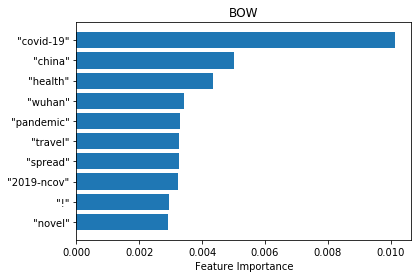


Accuracy: 80.955% ± 0.415%
F1 Score: 86.490% ± 0.319%

Running ML model: XGB
Features: BOW

Accuracy: 81.084% ± 0.354%
F1 Score: 86.416% ± 0.275%

Running ML model: RF
Features: POS


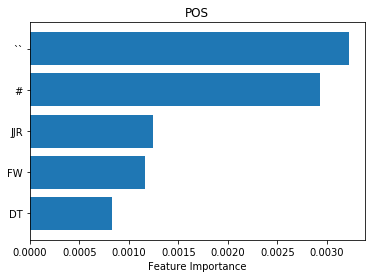


Accuracy: 70.889% ± 0.532%
F1 Score: 80.324% ± 0.311%

Running ML model: XGB
Features: POS

Accuracy: 71.081% ± 0.449%
F1 Score: 79.938% ± 0.303%

Running ML model: RF
Features: CFG


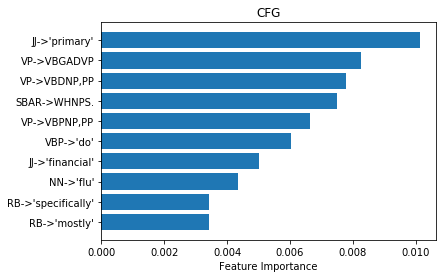


Accuracy: 80.346% ± 0.505%
F1 Score: 86.086% ± 0.387%

Running ML model: XGB
Features: CFG

Accuracy: 81.019% ± 0.653%
F1 Score: 86.431% ± 0.482%

Running ML model: RF
Features: DIA+CBA


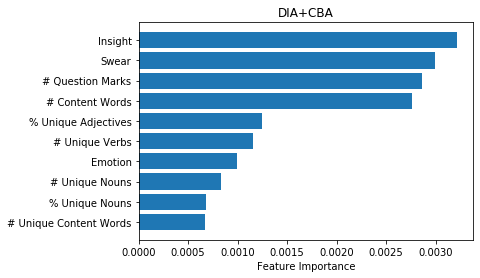


Accuracy: 72.171% ± 0.667%
F1 Score: 80.871% ± 0.390%

Running ML model: XGB
Features: DIA+CBA

Accuracy: 73.101% ± 0.534%
F1 Score: 81.217% ± 0.382%

Running ML model: RF
Features: RR


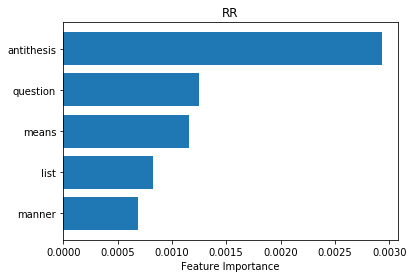


Accuracy: 66.687% ± 0.902%
F1 Score: 77.294% ± 0.696%

Running ML model: XGB
Features: RR

Accuracy: 67.489% ± 0.628%
F1 Score: 78.243% ± 0.464%

Running ML model: RF
Features: BOW+POS+CFG

Accuracy: 80.955% ± 0.504%
F1 Score: 86.519% ± 0.394%

Running ML model: XGB
Features: BOW+POS+CFG

Accuracy: 80.602% ± 0.841%
F1 Score: 86.053% ± 0.645%

Running ML model: RF
Features: BOW+DIA+CBA

Accuracy: 80.314% ± 0.372%
F1 Score: 86.102% ± 0.266%

Running ML model: XGB
Features: BOW+DIA+CBA

Accuracy: 81.083% ± 0.689%
F1 Score: 86.350% ± 0.553%

Running ML model: RF
Features: BOW+RR

Accuracy: 80.795% ± 0.428%
F1 Score: 86.470% ± 0.290%

Running ML model: XGB
Features: BOW+RR

Accuracy: 80.891% ± 0.522%
F1 Score: 86.209% ± 0.456%

Running ML model: RF
Features: POS+CFG+DIA+CBA

Accuracy: 79.962% ± 0.507%
F1 Score: 85.873% ± 0.326%

Running ML model: XGB
Features: POS+CFG+DIA+CBA

Accuracy: 81.115% ± 0.714%
F1 Score: 86.426% ± 0.543%

Running ML model: RF
Features: POS+CFG+RR

Accuracy: 80.154

In [97]:
di_acc, di_f1 = run_ml_algorithms('../Datasets/Preprocessed/dataset_i.csv',
                  '../Datasets/news_content_files/dataset_i',
                  '../Datasets/LIWC/dataset_i_title.csv',
                  '../Datasets/LIWC/dataset_i_text.csv')

Hyperparamters for RF
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 8, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Hyperparamters for XGB
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 500, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 0.6, 'verbosity': 1, 'weight': array([1.00782609, 0.99229452])}

Running ML model: RF
Features: BOW


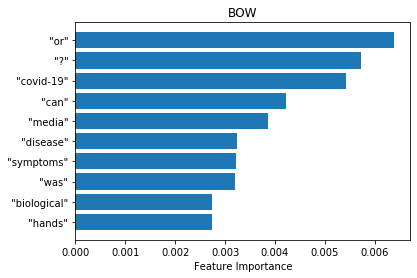


Accuracy: 92.062% ± 0.527%
F1 Score: 92.036% ± 0.529%

Running ML model: XGB
Features: BOW

Accuracy: 90.856% ± 0.854%
F1 Score: 90.870% ± 0.842%

Running ML model: RF
Features: POS


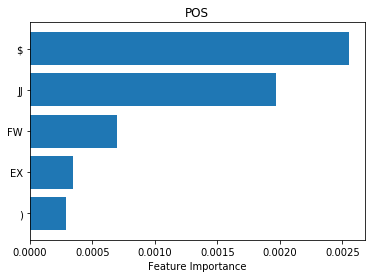


Accuracy: 80.499% ± 1.313%
F1 Score: 80.417% ± 1.290%

Running ML model: XGB
Features: POS

Accuracy: 81.276% ± 1.091%
F1 Score: 81.195% ± 1.223%

Running ML model: RF
Features: CFG


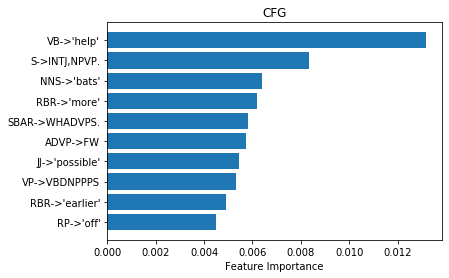


Accuracy: 91.803% ± 0.781%
F1 Score: 91.668% ± 0.791%

Running ML model: XGB
Features: CFG

Accuracy: 91.631% ± 0.684%
F1 Score: 91.618% ± 0.713%

Running ML model: RF
Features: DIA+CBA


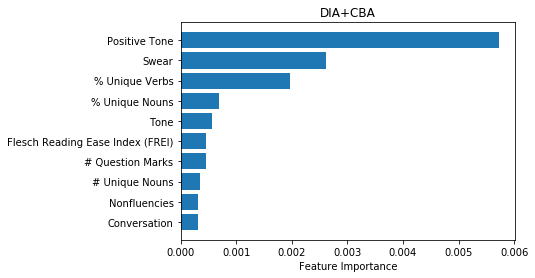


Accuracy: 83.605% ± 0.934%
F1 Score: 83.059% ± 0.943%

Running ML model: XGB
Features: DIA+CBA

Accuracy: 85.245% ± 0.529%
F1 Score: 85.178% ± 0.571%

Running ML model: RF
Features: RR


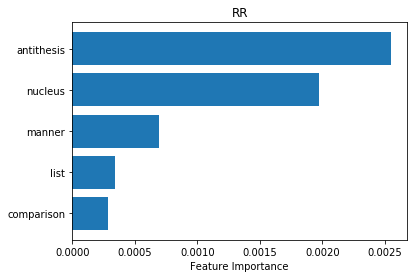


Accuracy: 68.508% ± 0.934%
F1 Score: 68.580% ± 1.047%

Running ML model: XGB
Features: RR

Accuracy: 65.660% ± 1.778%
F1 Score: 66.157% ± 1.594%

Running ML model: RF
Features: BOW+POS+CFG

Accuracy: 91.716% ± 0.593%
F1 Score: 91.583% ± 0.659%

Running ML model: XGB
Features: BOW+POS+CFG

Accuracy: 92.234% ± 0.733%
F1 Score: 92.171% ± 0.786%

Running ML model: RF
Features: BOW+DIA+CBA

Accuracy: 91.283% ± 0.811%
F1 Score: 91.062% ± 0.914%

Running ML model: XGB
Features: BOW+DIA+CBA

Accuracy: 91.629% ± 0.744%
F1 Score: 91.532% ± 0.801%

Running ML model: RF
Features: BOW+RR

Accuracy: 91.456% ± 0.633%
F1 Score: 91.313% ± 0.770%

Running ML model: XGB
Features: BOW+RR

Accuracy: 91.805% ± 0.435%
F1 Score: 91.804% ± 0.439%

Running ML model: RF
Features: POS+CFG+DIA+CBA

Accuracy: 90.767% ± 0.871%
F1 Score: 90.477% ± 0.953%

Running ML model: XGB
Features: POS+CFG+DIA+CBA

Accuracy: 92.491% ± 0.635%
F1 Score: 92.384% ± 0.724%

Running ML model: RF
Features: POS+CFG+RR

Accuracy: 90.940

In [98]:
dii_acc, dii_f1 = run_ml_algorithms('../Datasets/Preprocessed/dataset_ii.csv',
                  '../Datasets/news_content_files/dataset_ii',
                  '../Datasets/LIWC/dataset_ii_title.csv',
                  '../Datasets/LIWC/dataset_ii_text.csv')

# 10. Baseline Evaluation

### Generate Baseline Features

In [99]:
def nlp_baseline_feature(covid_series, covid_path, covid_liwc_title_file, covid_liwc_text_file, covid_p_file, nlp):
    """TF-IDF Vectorizer is set to ignore terms that occur in less than 2.5%
    of documents. CBA and DIA features are MinMax scaled to avoid these features dominating"""
    import pandas as pd
    from sklearn import preprocessing
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    general_p_file = '../Datasets/Preprocessed/baseline.csv'
    general_series = pd.read_csv('../Datasets/Preprocessed/baseline.csv')
    general_path = '../Datasets/news_content_files/baseline'
    general_liwc_title_file = '../Datasets/LIWC/baseline_title.csv'
    general_liwc_text_file = '../Datasets/LIWC/baseline_text.csv'
    
    vectorizer = TfidfVectorizer(min_df = 0.025, lowercase=False, tokenizer= lambda a : a.split())
    
    if nlp == 'BOW':
        bow_train = generate_bag_of_words(general_series['news_content'])
        bow_test = generate_bag_of_words(covid_series)
        vectorizer.fit(bow_train)
        bow_vect_train = vectorizer.transform(bow_train.values.astype('U'))
        bow_vect_test = vectorizer.transform(bow_test.values.astype('U'))
        return pd.DataFrame(bow_vect_train.toarray(), columns=vectorizer.get_feature_names()), pd.DataFrame(bow_vect_test.toarray(), columns=vectorizer.get_feature_names()), general_series['label']
    elif nlp == 'POS':
        pos_train = generate_part_of_speech_tags(general_series['news_content'])
        pos_test = generate_part_of_speech_tags(covid_series)
        pos_vect_train = vectorizer.fit_transform(pos_train.values.astype('U'))
        pos_vect_test = vectorizer.transform(pos_test.values.astype('U'))
        return pd.DataFrame(pos_vect_train.toarray(), columns=vectorizer.get_feature_names()), pd.DataFrame(pos_vect_test.toarray(), columns=vectorizer.get_feature_names()), general_series['label']
    elif nlp == 'CFG':
        cfg_train = generate_cfg_productions(general_path)
        cfg_test = generate_cfg_productions(covid_path)
        cfg_vect_train = vectorizer.fit_transform(cfg_train.values.astype('U'))
        cfg_vect_test = vectorizer.transform(cfg_test.values.astype('U'))
        return pd.DataFrame(cfg_vect_train.toarray(), columns=vectorizer.get_feature_names()), pd.DataFrame(cfg_vect_test.toarray(), columns=vectorizer.get_feature_names()), general_series['label']
    elif nlp == 'CBA':
        cba_train = all_cba_features(general_liwc_title_file, general_p_file, False)
        cba_test = all_cba_features(covid_liwc_title_file, covid_p_file, True)
        return pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(cba_train), columns=cba_train.columns), pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(cba_test), columns=cba_test.columns), general_series['label']
    elif nlp == 'DIA':
        dia_train = all_dia_features(general_liwc_text_file, general_p_file)
        dia_test = all_dia_features(covid_liwc_text_file, covid_p_file)
        return pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(dia_train), columns=dia_train.columns), pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(dia_test), columns=dia_test.columns), general_series['label']
    elif nlp == 'RR':
        rr_train = generate_rhetorical_relationships(general_path)
        rr_test = generate_rhetorical_relationships(covid_path)
        rr_vect_train = vectorizer.fit_transform(rr_train.values.astype('U'))
        rr_vect_test = vectorizer.transform(rr_test.values.astype('U'))
        return pd.DataFrame(rr_vect_train.toarray(), columns=vectorizer.get_feature_names()), pd.DataFrame(rr_vect_test.toarray(), columns=vectorizer.get_feature_names()), general_series['label']
    else:
        raise Exception(f'The following NLP is not currently handled: {nlp}')

In [100]:
def get_baseline_features(input_feature, path, liwc_title_file, liwc_text_file, p_file, feature_group):
    import pandas as pd
    args = (input_feature, path, liwc_title_file, liwc_text_file, p_file)

    def get_df(feature_list):
        return pd.concat(feature_list, axis=1)
        
    general, covid, label = zip(*[nlp_baseline_feature(*args, group) for group in feature_group.split('+')])
    return get_df(list(general)), get_df(list(covid)), label[0]

### Evaluate ML Algorithms against Baseline

In [117]:
def evaulate_ml_algorithms(file, path, liwc_title_file, liwc_text_file, RF_hyperparams, XGB_hyperparams):
    '''Feature selection is performed for both machine learning models with 80:20 cross-validation split'''
    import os
    os.environ['KMP_DUPLICATE_LIB_OK']='True'
    import pandas as pd
    import numpy as np
    import warnings
    from collections import defaultdict
    from sklearn.model_selection import StratifiedKFold
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from sklearn.metrics import f1_score, accuracy_score, make_scorer
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

    mydict= lambda: defaultdict(mydict)
    f1_scores, accuracies, latex_results = list(), list(), dict()
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for feature_group, language_level in combinations.items():
        latex_results[feature_group] = [language_level]
        covid_feature, covid_target = read_processed_file(file)
        general_fg, covid_fg, general_target = get_baseline_features(covid_feature, path, liwc_title_file, liwc_text_file, file, feature_group)
        weights = general_target.shape[0]/(np.bincount(general_target).shape[0]*np.bincount(general_target))
        algorithms = {'RF': RandomForestClassifier(**RF_hyperparams),
                     'XGB': XGBClassifier(**XGB_hyperparams)}
        
        for name, algorithm in algorithms.items():
            print(f'Running ML model: {name}')
            print(f'Features: {feature_group}')
            algorithm.fit(general_fg.to_numpy(), general_target)
            plot_feature_importance(name, feature_group, algorithm, general_fg)  
            covid_prediction = algorithm.predict(covid_fg.to_numpy())            
            acc = accuracy_score(covid_target, covid_prediction)     
            f1 = f1_score(covid_target, covid_prediction)

            # print the mean f1 score, mean accuracy, and the error
            print(f'\nAccuracy: {acc*100:.3f}%')
            print(f'F1 Score: {f1*100:.3f}%%\n')
          
            accuracies.append(acc)
            f1_scores.append(f1)
            
            latex_results[feature_group].append(f'{acc:.3f}'.replace('0.','.'))
            latex_results[feature_group].append(f'{f1:.3f}'.replace('0.','.'))
            
    print(f'\nPrint results to latex table')
    print_latex_table(latex_results)               
    return accuracies, f1_scores

Running ML model: RF
Features: BOW


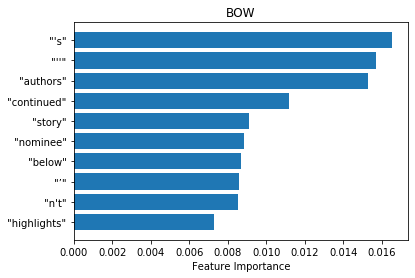


Accuracy: 36.775%
F1 Score: 22.969%%

Running ML model: XGB
Features: BOW

Accuracy: 36.935%
F1 Score: 25.010%%

Running ML model: RF
Features: POS


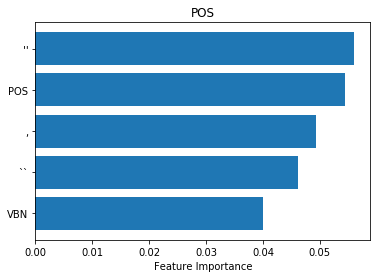


Accuracy: 44.662%
F1 Score: 47.346%%

Running ML model: XGB
Features: POS

Accuracy: 45.752%
F1 Score: 48.913%%

Running ML model: RF
Features: CFG


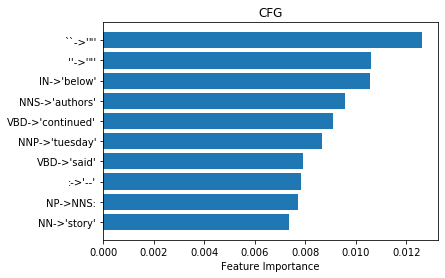


Accuracy: 38.891%
F1 Score: 29.407%%

Running ML model: XGB
Features: CFG

Accuracy: 36.422%
F1 Score: 22.448%%

Running ML model: RF
Features: DIA+CBA


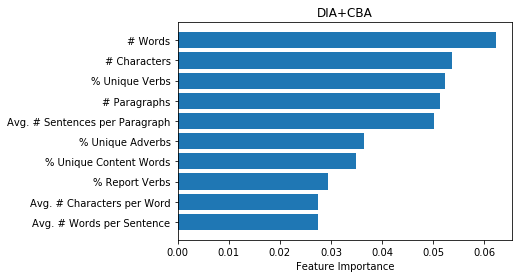


Accuracy: 33.697%
F1 Score: 11.473%%

Running ML model: XGB
Features: DIA+CBA

Accuracy: 34.851%
F1 Score: 8.054%%

Running ML model: RF
Features: RR


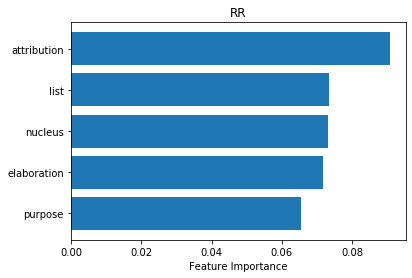


Accuracy: 46.585%
F1 Score: 50.739%%

Running ML model: XGB
Features: RR

Accuracy: 45.335%
F1 Score: 50.073%%

Running ML model: RF
Features: BOW+POS+CFG

Accuracy: 39.179%
F1 Score: 30.538%%

Running ML model: XGB
Features: BOW+POS+CFG

Accuracy: 37.127%
F1 Score: 25.972%%

Running ML model: RF
Features: BOW+DIA+CBA

Accuracy: 34.210%
F1 Score: 13.491%%

Running ML model: XGB
Features: BOW+DIA+CBA

Accuracy: 35.300%
F1 Score: 9.344%%

Running ML model: RF
Features: BOW+RR

Accuracy: 37.993%
F1 Score: 27.184%%

Running ML model: XGB
Features: BOW+RR

Accuracy: 37.384%
F1 Score: 26.330%%

Running ML model: RF
Features: POS+CFG+DIA+CBA

Accuracy: 38.025%
F1 Score: 28.275%%

Running ML model: XGB
Features: POS+CFG+DIA+CBA

Accuracy: 36.422%
F1 Score: 17.752%%

Running ML model: RF
Features: POS+CFG+RR

Accuracy: 39.307%
F1 Score: 31.980%%

Running ML model: XGB
Features: POS+CFG+RR

Accuracy: 37.929%
F1 Score: 28.296%%

Running ML model: RF
Features: DIA+CBA+RR

Accuracy: 34.242%
F1 Sco

In [119]:
di_baseline_acc, di_baseline_f1 = evaulate_ml_algorithms('../Datasets/Preprocessed/dataset_i.csv',
                                                         '../Datasets/news_content_files/dataset_i',
                                                         '../Datasets/LIWC/dataset_i_title.csv',
                                                         '../Datasets/LIWC/dataset_i_text.csv',
                                                         {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False},
                                                         {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'weight': [1.47400756, 0.75667152]})

Running ML model: RF
Features: BOW


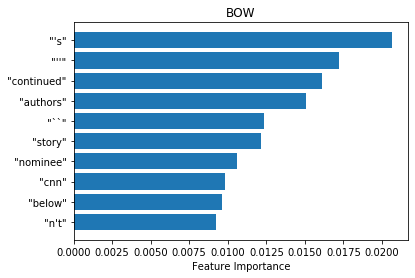


Accuracy: 49.094%
F1 Score: 17.135%%

Running ML model: XGB
Features: BOW

Accuracy: 51.855%
F1 Score: 27.154%%

Running ML model: RF
Features: POS


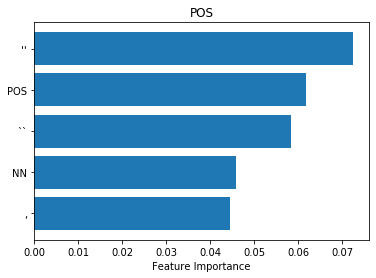


Accuracy: 45.557%
F1 Score: 28.050%%

Running ML model: XGB
Features: POS

Accuracy: 47.196%
F1 Score: 35.169%%

Running ML model: RF
Features: CFG


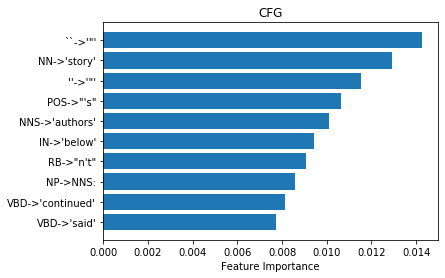


Accuracy: 50.733%
F1 Score: 24.371%%

Running ML model: XGB
Features: CFG

Accuracy: 49.612%
F1 Score: 26.263%%

Running ML model: RF
Features: DIA+CBA


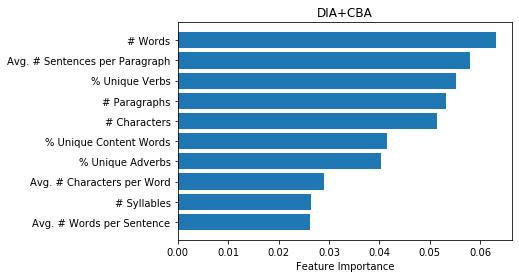


Accuracy: 46.160%
F1 Score: 22.581%%

Running ML model: XGB
Features: DIA+CBA

Accuracy: 47.282%
F1 Score: 19.287%%

Running ML model: RF
Features: RR


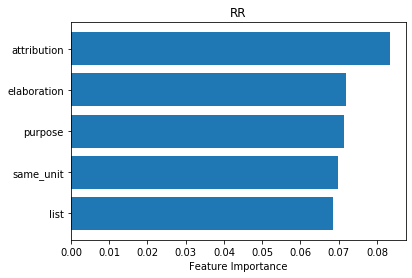


Accuracy: 48.145%
F1 Score: 41.021%%

Running ML model: XGB
Features: RR

Accuracy: 47.541%
F1 Score: 41.538%%

Running ML model: RF
Features: BOW+POS+CFG

Accuracy: 49.353%
F1 Score: 20.783%%

Running ML model: XGB
Features: BOW+POS+CFG

Accuracy: 48.576%
F1 Score: 25.871%%

Running ML model: RF
Features: BOW+DIA+CBA

Accuracy: 49.439%
F1 Score: 25.255%%

Running ML model: XGB
Features: BOW+DIA+CBA

Accuracy: 49.612%
F1 Score: 20.000%%

Running ML model: RF
Features: BOW+RR

Accuracy: 49.439%
F1 Score: 18.384%%

Running ML model: XGB
Features: BOW+RR

Accuracy: 50.216%
F1 Score: 25.162%%

Running ML model: RF
Features: POS+CFG+DIA+CBA

Accuracy: 49.612%
F1 Score: 28.606%%

Running ML model: XGB
Features: POS+CFG+DIA+CBA

Accuracy: 47.800%
F1 Score: 29.074%%

Running ML model: RF
Features: POS+CFG+RR

Accuracy: 49.525%
F1 Score: 21.477%%

Running ML model: XGB
Features: POS+CFG+RR

Accuracy: 49.094%
F1 Score: 28.398%%

Running ML model: RF
Features: DIA+CBA+RR

Accuracy: 46.764%
F1 Sc

In [120]:
dii_baseline_acc, dii_baseline_f1 = evaulate_ml_algorithms('../Datasets/Preprocessed/dataset_ii.csv',
                                                           '../Datasets/news_content_files/dataset_ii',
                                                           '../Datasets/LIWC/dataset_ii_title.csv',
                                                           '../Datasets/LIWC/dataset_ii_text.csv',
                                                           {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 8, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False},
                                                           {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 500, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 0.6, 'verbosity': 1, 'weight': [1.00782609, 0.99229452]})

### Perform Statistical Test - Mann-Whitney U Test

In [121]:
import scipy.stats as stats
alpha = 0.05
statistic_acc, p_value_acc = stats.mannwhitneyu((di_acc + dii_acc), (di_baseline_acc + dii_baseline_acc), alternative='greater')
statistic_f1, p_value_f1 = stats.mannwhitneyu((di_f1 + dii_f1), (di_baseline_f1 + dii_baseline_f1), alternative='greater')
                                              
if p_value_acc < alpha:
    print("There is a significant difference in accuracies between the two models.")
else:
    print("There is NO significant difference in accuracies between the two models.")
                                              
if p_value_f1 < alpha:
    print("There is a significant difference in f1-scores between the two models.")
else:
    print("There is NO significant difference in f1-scores between the two models.")

There is a significant difference in accuracies between the two models.
There is a significant difference in f1-scores between the two models.


In [122]:
p_value_acc

8.54413943025355e-23

In [123]:
p_value_f1

8.564151458702349e-23

# Generating Baseline Data

In [124]:
def general_datasets_to_csv(dataset):
    import os
    import json
    import pandas as pd
    data = list()
    for root, _, files in os.walk(f'../FakeNewsNet/Data/{dataset}/FakeNewsContent/'):
        for file in files:
            with open(os.path.join(root, file)) as f:
                content = json.load(f)
                data.append((content['title'],content['text'], 0))
    for root, _, files in os.walk(f'../FakeNewsNet/Data/{dataset}/RealNewsContent/'):
        for file in files:
            with open(os.path.join(root, file)) as f:
                content = json.load(f)
                data.append((content['title'],content['text'], 1))

    df = pd.DataFrame(data, columns =['title', 'text', 'label'])
    df.to_csv(f'../Datasets/Original/{dataset}.csv') 

In [117]:
general_datasets_to_csv('buzzfeed')
general_datasets_to_csv('politifact')

In [118]:
import pandas as pd

preprocess_text_column('../Datasets/Original/buzzfeed.csv', '../Datasets/Preprocessed/buzzfeed.csv')
preprocess_text_column('../Datasets/Original/politifact.csv', '../Datasets/Preprocessed/politifact.csv')

pd.concat([pd.read_csv('../Datasets/Preprocessed/buzzfeed.csv'), 
           pd.read_csv('../Datasets/Preprocessed/politifact.csv')]).reset_index(drop=True)\
           .to_csv(f'../Datasets/Preprocessed/baseline.csv') 

news_content_to_files('../Datasets/Preprocessed/buzzfeed.csv', '../Datasets/news_content_files/buzzfeed')
news_content_to_files('../Datasets/Preprocessed/politifact.csv', '../Datasets/news_content_files/politifact')
news_content_to_files('../Datasets/Preprocessed/baseline.csv', '../Datasets/news_content_files/baseline')

In [24]:
generate_cfg_parse_docs('../Datasets/news_content_files/buzzfeed')
generate_cfg_parse_docs('../Datasets/news_content_files/politifact')
generate_cfg_parse_docs('../Datasets/news_content_files/baseline')

In [25]:
%%sh
cd "../RR_DPLP_Parser"
/Library/Frameworks/Python.framework/Versions/2.7/bin/python convert.py ../Datasets/news_content_files/buzzfeed
/Library/Frameworks/Python.framework/Versions/2.7/bin/python convert.py ../Datasets/news_content_files/politifact
/Library/Frameworks/Python.framework/Versions/2.7/bin/python convert.py ../Datasets/news_content_files/baseline

Processing file: ../Datasets/news_content_files/buzzfeed/file_79.xml
Processing file: ../Datasets/news_content_files/buzzfeed/file_45.xml
Processing file: ../Datasets/news_content_files/buzzfeed/file_51.xml
Processing file: ../Datasets/news_content_files/buzzfeed/file_86.xml
Processing file: ../Datasets/news_content_files/buzzfeed/file_92.xml
Processing file: ../Datasets/news_content_files/buzzfeed/file_159.xml
Processing file: ../Datasets/news_content_files/buzzfeed/file_165.xml
Processing file: ../Datasets/news_content_files/buzzfeed/file_171.xml
Processing file: ../Datasets/news_content_files/buzzfeed/file_170.xml
Processing file: ../Datasets/news_content_files/buzzfeed/file_164.xml
Processing file: ../Datasets/news_content_files/buzzfeed/file_158.xml
Processing file: ../Datasets/news_content_files/buzzfeed/file_93.xml
Processing file: ../Datasets/news_content_files/buzzfeed/file_87.xml
Processing file: ../Datasets/news_content_files/buzzfeed/file_50.xml
Processing file: ../Datasets

In [26]:
%%sh
cd "../RR_DPLP_Parser"
/Library/Frameworks/Python.framework/Versions/2.7/bin/python segmenter.py ../Datasets/news_content_files/buzzfeed
/Library/Frameworks/Python.framework/Versions/2.7/bin/python segmenter.py ../Datasets/news_content_files/politifact
/Library/Frameworks/Python.framework/Versions/2.7/bin/python segmenter.py ../Datasets/news_content_files/baseline

Load model from: discoseg/pretrained/model.pickle.gz
Processing file: ../Datasets/news_content_files/buzzfeed/file_109.conll
Processing file: ../Datasets/news_content_files/buzzfeed/file_171.conll
Processing file: ../Datasets/news_content_files/buzzfeed/file_134.conll
Processing file: ../Datasets/news_content_files/buzzfeed/file_34.conll
Processing file: ../Datasets/news_content_files/buzzfeed/file_71.conll
Processing file: ../Datasets/news_content_files/buzzfeed/file_155.conll
Processing file: ../Datasets/news_content_files/buzzfeed/file_110.conll
Processing file: ../Datasets/news_content_files/buzzfeed/file_10.conll
Processing file: ../Datasets/news_content_files/buzzfeed/file_55.conll
Processing file: ../Datasets/news_content_files/buzzfeed/file_68.conll
Processing file: ../Datasets/news_content_files/buzzfeed/file_95.conll
Processing file: ../Datasets/news_content_files/buzzfeed/file_168.conll
Processing file: ../Datasets/news_content_files/buzzfeed/file_97.conll
Processing file: .

In [27]:
%%sh
cd "../RR_DPLP_Parser"
/Library/Frameworks/Python.framework/Versions/2.7/bin/python rstparser.py ../Datasets/news_content_files/buzzfeed
/Library/Frameworks/Python.framework/Versions/2.7/bin/python rstparser.py ../Datasets/news_content_files/politifact
/Library/Frameworks/Python.framework/Versions/2.7/bin/python rstparser.py ../Datasets/news_content_files/baseline

Read files from: ../Datasets/news_content_files/buzzfeed
Load Brown clusters for creating features ...
Load parsing model ...
Finish initializing ParsingModel
Load model from file: model/parsing-model.pickle.gz
Reading
../Datasets/news_content_files/buzzfeed/file_128.merge
 ( NS-elaboration ( SN-attribution ( EDU 1 )  ( EDU 2 )  )  ( NN-textualorganization ( EDU 3 )  ( NS-elaboration ( NS-elaboration ( EDU 4 )  ( EDU 5 )  )  ( NS-elaboration ( NS-elaboration ( EDU 6 )  ( EDU 7 )  )  ( NN-list ( NN-list ( NS-attribution ( EDU 8 )  ( EDU 9 )  )  ( NS-elaboration ( NS-elaboration ( EDU 10 )  ( NS-temporal ( EDU 11 )  ( EDU 12 )  )  )  ( NS-elaboration ( NN-same_unit ( NS-elaboration ( EDU 13 )  ( EDU 14 )  )  ( NN-same_unit ( EDU 15 )  ( EDU 16 )  )  )  ( NS-elaboration ( NS-elaboration ( EDU 17 )  ( NS-purpose ( NS-purpose ( EDU 18 )  ( EDU 19 )  )  ( EDU 20 )  )  )  ( NS-elaboration ( EDU 21 )  ( EDU 22 )  )  )  )  )  )  ( NN-list ( EDU 23 )  ( NN-topic ( NS-attribution ( NS-elaboration

In [33]:
perform_liwc('../Datasets/Preprocessed/buzzfeed.csv', '../Datasets/LIWC/buzzfeed_title.csv', '1')
perform_liwc('../Datasets/Preprocessed/buzzfeed.csv', '../Datasets/LIWC/buzzfeed_text.csv', '2')
perform_liwc('../Datasets/Preprocessed/politifact.csv', '../Datasets/LIWC/politifact_title.csv', '1')
perform_liwc('../Datasets/Preprocessed/politifact.csv', '../Datasets/LIWC/politifact_text.csv', '2')
perform_liwc('../Datasets/Preprocessed/baseline.csv', '../Datasets/LIWC/baseline_title.csv', '1')
perform_liwc('../Datasets/Preprocessed/baseline.csv', '../Datasets/LIWC/baseline_text.csv', '2')

Hyperparamters for RF
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Hyperparamters for XGB
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1, 'missing': None, 'n_estimators': 500, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 0.8, 'verbosity': 1, 'weight': array([1., 1.])}

Running ML model: RF
Features: BOW


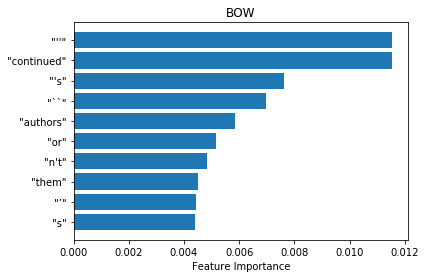


Accuracy: 79.084% ± 1.755%
F1 Score: 77.535% ± 1.867%

Running ML model: XGB
Features: BOW

Accuracy: 73.589% ± 1.595%
F1 Score: 72.993% ± 1.620%

Running ML model: RF
Features: POS


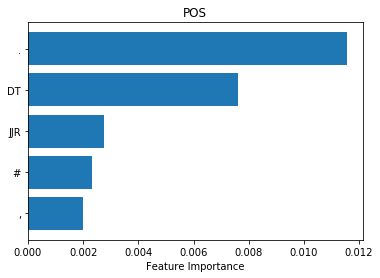


Accuracy: 72.477% ± 2.688%
F1 Score: 71.219% ± 2.774%

Running ML model: XGB
Features: POS

Accuracy: 71.396% ± 2.220%
F1 Score: 70.695% ± 2.215%

Running ML model: RF
Features: CFG


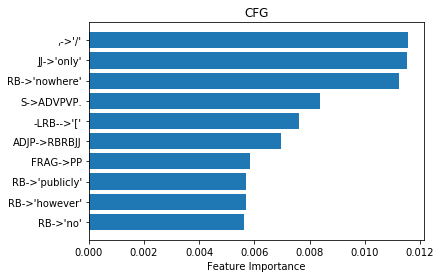


Accuracy: 82.417% ± 1.462%
F1 Score: 80.979% ± 1.467%

Running ML model: XGB
Features: CFG

Accuracy: 76.847% ± 3.277%
F1 Score: 76.523% ± 2.986%

Running ML model: RF
Features: DIA+CBA


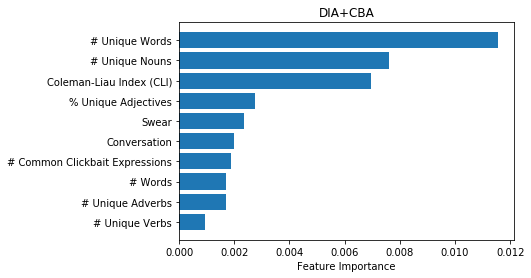


Accuracy: 68.634% ± 4.684%
F1 Score: 68.455% ± 4.683%

Running ML model: XGB
Features: DIA+CBA

Accuracy: 74.144% ± 3.014%
F1 Score: 72.272% ± 3.530%

Running ML model: RF
Features: RR


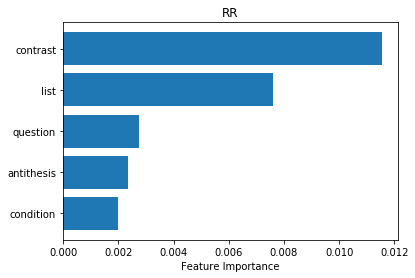


Accuracy: 60.495% ± 2.184%
F1 Score: 58.399% ± 2.925%

Running ML model: XGB
Features: RR

Accuracy: 60.495% ± 4.696%
F1 Score: 58.776% ± 6.023%

Running ML model: RF
Features: BOW+POS+CFG

Accuracy: 81.877% ± 0.935%
F1 Score: 80.427% ± 1.075%

Running ML model: XGB
Features: BOW+POS+CFG

Accuracy: 74.715% ± 0.973%
F1 Score: 73.693% ± 1.531%

Running ML model: RF
Features: BOW+DIA+CBA

Accuracy: 77.417% ± 2.940%
F1 Score: 76.108% ± 2.855%

Running ML model: XGB
Features: BOW+DIA+CBA

Accuracy: 79.069% ± 2.099%
F1 Score: 77.804% ± 2.714%

Running ML model: RF
Features: BOW+RR

Accuracy: 80.751% ± 1.401%
F1 Score: 78.868% ± 1.890%

Running ML model: XGB
Features: BOW+RR

Accuracy: 75.781% ± 1.559%
F1 Score: 74.607% ± 1.780%

Running ML model: RF
Features: POS+CFG+DIA+CBA

Accuracy: 80.165% ± 2.209%
F1 Score: 78.805% ± 2.264%

Running ML model: XGB
Features: POS+CFG+DIA+CBA

Accuracy: 79.084% ± 2.077%
F1 Score: 78.394% ± 2.539%

Running ML model: RF
Features: POS+CFG+RR

Accuracy: 79.069

In [125]:
b_results = run_ml_algorithms('../Datasets/Preprocessed/buzzfeed.csv',
                  '../Datasets/news_content_files/buzzfeed',
                  '../Datasets/LIWC/buzzfeed_title.csv',
                  '../Datasets/LIWC/buzzfeed_text.csv', False)

Hyperparamters for RF
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Hyperparamters for XGB
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1, 'missing': None, 'n_estimators': 500, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 0.6, 'verbosity': 1, 'weight': array([1., 1.])}

Running ML model: RF
Features: BOW


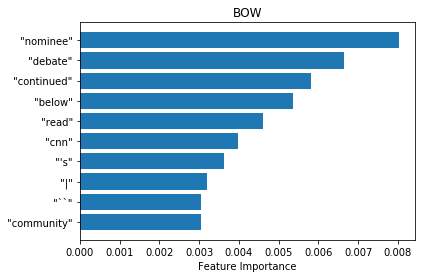


Accuracy: 87.083% ± 1.369%
F1 Score: 86.139% ± 1.613%

Running ML model: XGB
Features: BOW

Accuracy: 79.583% ± 1.990%
F1 Score: 79.238% ± 2.202%

Running ML model: RF
Features: POS


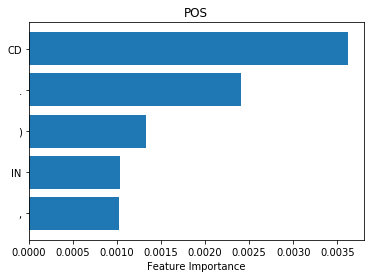


Accuracy: 75.833% ± 0.745%
F1 Score: 74.517% ± 0.990%

Running ML model: XGB
Features: POS

Accuracy: 73.333% ± 0.697%
F1 Score: 72.533% ± 0.958%

Running ML model: RF
Features: CFG


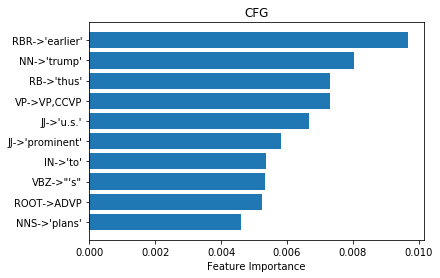


Accuracy: 83.750% ± 1.603%
F1 Score: 82.022% ± 2.112%

Running ML model: XGB
Features: CFG

Accuracy: 81.667% ± 1.491%
F1 Score: 80.366% ± 1.958%

Running ML model: RF
Features: DIA+CBA


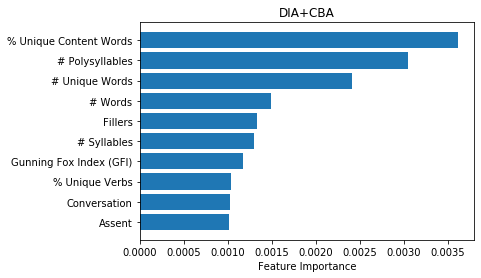


Accuracy: 76.250% ± 2.252%
F1 Score: 76.176% ± 2.136%

Running ML model: XGB
Features: DIA+CBA

Accuracy: 69.167% ± 2.528%
F1 Score: 69.407% ± 2.350%

Running ML model: RF
Features: RR


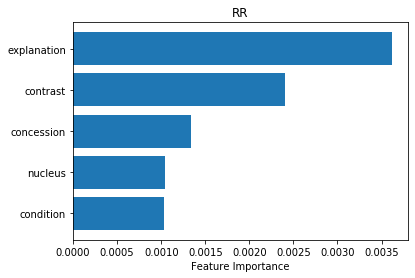


Accuracy: 57.917% ± 0.913%
F1 Score: 59.598% ± 2.367%

Running ML model: XGB
Features: RR

Accuracy: 62.083% ± 1.990%
F1 Score: 63.253% ± 3.067%

Running ML model: RF
Features: BOW+POS+CFG

Accuracy: 86.667% ± 1.918%
F1 Score: 85.319% ± 2.518%

Running ML model: XGB
Features: BOW+POS+CFG

Accuracy: 84.167% ± 1.264%
F1 Score: 83.221% ± 1.612%

Running ML model: RF
Features: BOW+DIA+CBA

Accuracy: 84.167% ± 2.092%
F1 Score: 82.377% ± 3.152%

Running ML model: XGB
Features: BOW+DIA+CBA

Accuracy: 77.500% ± 4.142%
F1 Score: 76.691% ± 4.837%

Running ML model: RF
Features: BOW+RR

Accuracy: 85.833% ± 1.491%
F1 Score: 84.657% ± 1.888%

Running ML model: XGB
Features: BOW+RR

Accuracy: 78.750% ± 4.014%
F1 Score: 78.487% ± 4.574%

Running ML model: RF
Features: POS+CFG+DIA+CBA

Accuracy: 82.500% ± 1.514%
F1 Score: 81.000% ± 2.049%

Running ML model: XGB
Features: POS+CFG+DIA+CBA

Accuracy: 83.750% ± 0.913%
F1 Score: 82.856% ± 1.272%

Running ML model: RF
Features: POS+CFG+RR

Accuracy: 85.000

In [126]:
p_results = run_ml_algorithms('../Datasets/Preprocessed/politifact.csv',
                  '../Datasets/news_content_files/politifact',
                  '../Datasets/LIWC/politifact_title.csv',
                  '../Datasets/LIWC/politifact_text.csv', False)

# NLTK -v- SpaCy Sentence Tokeniser

In [114]:
import spacy
import pandas as pd
from nltk.tokenize import sent_tokenize
from nltk.parse import CoreNLPParser

nlp = spacy.load('en_core_web_md')
parser = CoreNLPParser(url='http://localhost:9000')

In [116]:
#Doc 210[92] in Dataset 1

document = '(For further details and updates, as well as information about operations in the United States, contact GAC North America at [email protected] )\
Source: U.S. Coast Guard, Sector Virginia, Marine Safety Information Bulletin No.20-026 dated February 2, 2020\
Coronavirus measures updates (5 February)\
Wednesday, February 5, 2020, Australia\
The Australian Border Force has advised that the 14-day quarantine period for vessels that has left mainland China on or after 1 February 2020 commences from the date of departure from China, and NOT from arrival in Australia (unless there are crew with symptoms).\
Other updates from individual ports include:\
PORTLAND\
The Health Declaration form must be completed and sent to the Port of Portland office by all vessels prior to the pilot boarding the vessel.\
PORT WALCOTT\
Rio Tinto requests all vessels to send through a copy of Bio Security Document and Customs forms 13 and 3B, or last vessels port visited and crew nationalities.\
PORT HEDLAND\
BHP have amended the pilot pre-arrival form with added questions about if the ship had been to china and all crew are healthy.'

In [168]:
import pandas as pd
from sklearn import tree
import graphviz 
clf = tree.DecisionTreeClassifier()
for i in range(1, 60, 20):
    X = get_quantity_counts('../Datasets/Preprocessed/dataset_ii.csv')[i:i+20]
    _, y = read_processed_file('../Datasets/Preprocessed/dataset_ii.csv')
    y = y[i:i+20]
    clf = clf.fit(X, y)
    dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=X.columns,  
                     class_names=['Fake', 'Real'],  
                      filled=True, rounded=True,                  
                                 special_characters=True) 
    graph = graphviz.Source(dot_data) 
    graph.render(f'dtree_{i}')